### This notebook presents code to accompany the paper

# A flexible data and knowledge-driven method for identifying climate drivers to predict summer conditions in China’s Northeast Farming Region 
Edward POPE$^{1}$*, 
Nathan CREASER$^{1}$, 
Kevin DONKERS$^{1}$, 
Andrew COTTRELL$^{1}$, 
Jemma DAVIE$^{1}$, 
Chris KENT$^{1}$, 
Catherine BRADSHAW$^{1}$, 
James BACON$^{1}$, 
Samantha ADAMS$^{1}$, 
Tom CROCKER$^{1}$, 
Peiqun ZHANG$^{2}$, 
Zhan TIAN$^{3}$

$^{1}$ Met Office, Exeter, EX1 3PB, UK<br>
$^{2}$ Beijing Climate Centre, China Meteorological Administration, Beijing, China<br>
$^{3}$ School of Environmental Science and Engineering, Southern University of Science and Technology, Shenzhen, China<br>
\* Corresponding author: edward.pope@metoffice.gov.uk 

## Table of Contents

This notebook contains all the nessacary methods to conduct the approach outlined in the paper:

### Section 1: [Feature collection](#section_1)
* Standardising and detrending data 

### Section 2: [Feature filter](#section_2)
* Remove all features that are very poorly correlated with temperature

### Section 3: [Feature selection](#section_3)
* Run the rest through the random forest to find the most useful features 

### Section 4: [Feature refinement](#section_4)
* Creating Bayseian Networks between selected jet and climate indices 
    
### Section 5: [Feature explainability](../Dynamics/2D_correlation_plots.ipynb) (not in this notebook)
* See `./Dynamics/2D_correlation_plots.ipynb`

### Section 6: [Statistical forecast](#section_6)
* Linear Regression

<a id='section_1'></a>
## Section 1: Feature collection
* Standardising and detrending data 

#### Regional temperature data
Annual JJA 2m air temperature was collected from ERA5 for each province in the NFR, weighted to maize harvest area for the year 2000 (Monfreda et al, 2008). The data is available as a CSV file: [`data/csv/temp_jja_NE_china.csv`](../data/csv/temp_jja_NE_china.csv). Information on the source of the data can be found in [`data/README.md`](../data/README.md). 

#### Climate index data
In this work we collect around 25 different climate indices on monthly timescales. To simplify this notebook the climate indices have been collated into a single CSV file: [`data/csv/climate_indices.csv`](../data/csv/climate_indices.csv). Information on the climate indices and their sources can be found in [`data/README.md`](../data/README.md), including abbreviation expansions. 

Monthly climate indices are identified by their month and abbreviation in the format <abbreviation>-<month_number> e.g. `peu-5` represents Polar Eurasian index in May. Take note that years identified for each index are for the months **preceeding** boreal summer of that year. For example, `wpsh-9` in the 1981 row represents the WPSH index in November 1980.

#### Detrending 

Firstly we detrend our data with a linear model. This ensures our data is stationary by removing any nonstationarities, such as the influence of climate change. 

#### Standardising 

Secondly we standardise our data, which sets `mean = 0, standard deviation = 1` for each variable

In [1]:
empty_matrix <- function(rownames, colnames){
    empty_array = array(NA, c(length(rownames), length(colnames)))
    rownames(empty_array) = rownames
    colnames(empty_array) = colnames 
    return(empty_array)
}

In [2]:
region = "NE_China"
# provinces = c("Heilongjiang", "Jilin", "Liaoning")
provinces = c("Liaoning", "Jilin", "Heilongjiang")

### Regional temperature data

Load annual JJA temperature for provinces in NFR from CSV file

In [3]:
temp_jja_fname = '../data/csv/temp_jja_NE_China_1981-2016.csv'
temp_jja = read.csv(temp_jja_fname, header = TRUE, sep = ",", stringsAsFactors = FALSE)
head(temp_jja)

,Liaoning,Jilin,Heilongjiang
,<dbl>,<dbl>,<dbl>
1981,22.61073,21.62084,20.11407
1982,22.96797,22.92326,21.90634
1983,22.26246,20.61599,19.13693
1984,22.61542,21.94940,20.54990
1985,22.32568,21.85647,20.67396
1986,21.77447,21.17251,20.37019


Rename, detrend and standardise data for each region.
- Detrending uses `lm` function
- Standardisation uses `scale` function

In [4]:
years = as.numeric(rownames(temp_jja))
temp_abs = empty_matrix(years, provinces)
temp_anoms = empty_matrix(years, provinces)

for (k in 1:length(colnames(temp_anoms))) {
    timesteps = 1:length(temp_jja[,k])
    detrend = lm(temp_jja[,k] ~ timesteps)$residuals
    standardised = scale(detrend)
    temp_abs[,k] = detrend
    temp_anoms[,k] = standardised
}  

In [5]:
head(temp_abs)
head(temp_anoms)

,Liaoning,Jilin,Heilongjiang
1981,0.28022658,-0.05251572,-0.36212503
1982,0.61488039,1.22282723,1.40008929
1983,-0.11321579,-1.11151983,-1.39937639
1984,0.21715802,0.19481312,-0.01646207
1985,-0.09516816,0.07480606,0.07754225
1986,-0.66896435,-0.63623099,-0.25628343


,Liaoning,Jilin,Heilongjiang
1981,0.4767537,-0.07799843,-0.53412111
1982,1.0461054,1.81619148,2.06508026
1983,-0.1926158,-1.65087332,-2.06402876
1984,0.3694542,0.28934417,-0.02428095
1985,-0.1619110,0.11110493,0.11437196
1986,-1.1381192,-0.94495550,-0.37800865


### Climate index data

Load monthly climate index data from CSV file, renaming replacing `.` with `-` in the column names

In [6]:
climate_indices_fname = '../data/csv/climate_indices_1981-2016.csv'
climate_indices = read.csv(climate_indices_fname, header = TRUE,sep = ",", stringsAsFactors = FALSE)
colnames(climate_indices) <- gsub("[[:punct:]]", "-", colnames(climate_indices))
head(climate_indices)

,wpsh-9,wpsh-10,wpsh-11,wpsh-12,wpsh-1,wpsh-2,wpsh-3,wpsh-4,wpsh-5,iod-9,⋯,mjopc1b-5,amo-9,amo-10,amo-11,amo-12,amo-1,amo-2,amo-3,amo-4,amo-5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1981,14647.72,14855.22,14874.19,14754.29,14840.38,14823.92,14974.42,14865.94,14733.79,-0.639,⋯,0.3135853,-0.14,-0.15,-0.15,-0.15,-0.15,-0.16,-0.16,-0.16,-0.16
1982,14724.16,14813.61,14881.97,14928.39,14844.86,14816.04,14831.94,14822.94,14803.69,-0.651,⋯,-0.8869489,-0.16,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,-0.16,-0.16
1983,14697.37,14787.07,15000.44,14983.69,15086.88,14982.15,14953.99,14939.12,14837.90,0.548,⋯,-1.2200562,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16
1984,14788.31,14886.98,14866.77,14894.84,14774.50,14744.34,14836.41,14743.72,14685.91,0.037,⋯,1.0038773,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15
1985,14756.51,14682.57,14898.16,14755.96,14815.74,14657.85,14918.78,14622.10,14663.60,-0.502,⋯,0.9774278,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.16
1986,14790.06,14870.71,14887.35,14840.96,14812.80,14745.91,14785.91,14862.11,14621.19,-0.132,⋯,-0.3579582,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.17,-0.17


Keep a list of the climate indices and months we are most interested in (will be used a lot in later sections)

In [7]:
ind_list = c("wpsh", "iod", "pdo", "nin3","seu", "nao", "snao", "scand", "ao", "eawr", "peu", "cgt", "pstratu", "mjopc1a", "mjopc1b", "amo")
cmons_num = c(9,10,11,12,1,2,3,4,5)

Detrend and standardise each `cindex-month`.
- Detrend using `lm` function
- Standardise using `scale` function

In [8]:
cindex_anoms = empty_matrix(rownames(climate_indices), colnames(climate_indices))

for (s in 1:dim(climate_indices)[2]) {
    timesteps = 1:dim(climate_indices)[1]
    detrend = lm(climate_indices[,s] ~ timesteps)$residuals
    standardised = scale(detrend)
    cindex_anoms[,s] = standardised
}

In [9]:
head(cindex_anoms)

,wpsh-9,wpsh-10,wpsh-11,wpsh-12,wpsh-1,wpsh-2,wpsh-3,wpsh-4,wpsh-5,iod-9,⋯,mjopc1b-5,amo-9,amo-10,amo-11,amo-12,amo-1,amo-2,amo-3,amo-4,amo-5
1981,-0.81403246,0.3908544,-0.4832602,-1.79450205,-0.5490223,-0.2333582,1.1935139,0.60339529,-0.1832748,-1.201899209,⋯,0.2940131,1.299626222,1.14105248,1.0942301,1.05689299,1.03964024,0.90265360,0.88897409,0.7729054,0.75323034
1982,0.27045373,-0.1548922,-0.3574754,0.08064204,-0.5024673,-0.3294853,-0.5197873,0.07973675,0.7816871,-1.263696128,⋯,-1.3135036,0.762324208,0.60299290,0.5619158,0.52692667,0.51459353,0.54373150,0.52593390,0.6010720,0.58203490
1983,-0.09435666,-0.5000170,1.6245257,0.67717440,2.4069856,1.3393430,0.9469850,1.46479417,1.2537764,1.890814598,⋯,-1.7531080,0.573753485,0.58878967,0.5485361,0.51414677,0.50180359,0.52872662,0.51198378,0.4292385,0.41083947
1984,1.19371570,0.8395346,-0.6218910,-0.27775697,-1.3654123,-1.0892955,-0.4670106,-0.88611513,-0.8449340,0.503718327,⋯,1.2501129,0.559548407,0.57458645,0.5351565,0.50136687,0.48901366,0.51372174,0.49803365,0.4215489,0.40374329
1985,0.75847369,-1.8752372,-0.1000867,-1.77105230,-0.8759027,-1.9828740,0.5227434,-2.35231562,-1.1530700,-0.957743439,⋯,1.2233955,0.370977684,0.38576443,0.3487986,0.31619150,0.30547146,0.32675824,0.30953850,0.2497155,0.06844861
1986,1.24078063,0.6398621,-0.2861184,-0.85493696,-0.9188377,-1.1057450,-1.0751083,0.51735794,-1.7388319,-0.004982538,⋯,-0.5656869,0.008041316,0.02232364,-0.0105375,-0.04137935,-0.04882299,-0.03216386,-0.05350168,-0.2504056,-0.26684608


### East Asian jet data
Load data for the East Asian jets:
```
uwind = zonal wind
vwind = meridional wind
eapj  = East Asian Polar Jet
easj  = East Asian Subtropical Jet
```

In [10]:
ndata = "../data/csv/"
j1u = "eapj_uwind_200hPa_monthly_custom.csv"
#j1u = "eapj_uwind_200hPa_monthly_huang2014.csv"

# j1v = "eapj_vwind_200hPa_monthly_custom.csv"
j1v = "eapj_vwind_200hPa_monthly_huang2014.csv"

j2u = "easj_uwind_200hPa_monthly_custom.csv"
#j2u ="easj_uwind_200hPa_monthly_huang2014.csv"

j2v = "easj_vwind_200hPa_monthly_custom.csv"
#j2u ="easj_vwind_200hPa_monthly_huang2014.csv"

# read yield, T and P data
j1udat = read.csv(paste(ndata,j1u, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)
j1vdat = read.csv(paste(ndata,j1v, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

j2udat = read.csv(paste(ndata,j2u, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)
j2vdat = read.csv(paste(ndata,j2v, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

In [11]:
##### We havn't done anything with jets yet 
ystrt = 1981
yend = 2016
indyrsjet = which(j1udat[,1] == ystrt):which(j1udat[,1] == yend)

## calcaulte jja mean and de-trend
jmons = c("Mar", "Apr", "May", "Jun", "Jul", "Aug")
jmons_num = c(3,4,5,6,7,8)

j1ujja = j1udat[indyrsjet, jmons] 

colnames(j1ujja) = paste("eapju",jmons_num, sep="-")

j2ujja = j2udat[indyrsjet, jmons] 
colnames(j2ujja) = paste("easju",jmons_num, sep="-")

j1vjja = j1vdat[indyrsjet, jmons] 
colnames(j1vjja) = paste("eapjv",jmons_num, sep="-")

j2vjja = j2vdat[indyrsjet, jmons] 
colnames(j2vjja) = paste("easjv",jmons_num, sep="-")

jet_raw = as.matrix(cbind(j1ujja, j1vjja, j2ujja, j2vjja))

In [12]:
jet_anoms = array(NA, c(dim(jet_raw)[1], dim(jet_raw)[2]))
colnames(jet_anoms) = colnames(jet_raw)
rownames(jet_anoms) = rownames(cindex_anoms)

In [13]:
for (s in 1:dim(jet_raw)[2]) {
  # de-trend
  timesteps = 1:dim(jet_raw)[1]
  mod = lm(jet_raw[,s] ~ timesteps)
  jet_anoms[,s] = scale(mod$residual)
}

In [14]:
head(jet_anoms)

,eapju-3,eapju-4,eapju-5,eapju-6,eapju-7,eapju-8,eapjv-3,eapjv-4,eapjv-5,eapjv-6,⋯,easju-5,easju-6,easju-7,easju-8,easjv-3,easjv-4,easjv-5,easjv-6,easjv-7,easjv-8
1981,-0.2673068,1.2258024,-0.5146467,-1.1501056,1.43970881,-2.0421761,-0.07614528,-0.4612346,-1.8504838,0.7772000,⋯,-0.48673140,-0.6282208,-2.2073739,1.51223567,-0.22976396,0.1282359,-0.96941338,-0.5659394,-0.3153362,-1.2941930
1982,0.8123170,0.5704176,-0.8585113,0.3646483,-0.08194652,2.1049598,1.32564974,1.6217820,1.2080584,-1.0640218,⋯,-0.60694055,-0.3667581,0.8292086,-0.63889096,0.86244156,-0.3491913,-0.05873459,-0.7617309,-1.3284011,0.4868199
1983,-0.6832619,-0.8345114,-0.5340283,-1.4612080,0.37957390,-0.1938942,0.59598436,-0.3662604,-0.8157827,0.1685579,⋯,-0.03655568,1.5908256,1.9673861,-0.89879682,-0.43175536,1.8754094,0.24764264,0.6787895,0.3055203,0.7625471
1984,-2.3025715,-0.4629560,-0.3536772,-0.2555354,-1.31556333,0.4297542,1.21686468,-1.1355198,0.9086090,-1.4274640,⋯,-0.32735049,0.2254724,0.8402152,-0.35304954,-2.50680485,-0.9965782,0.67392176,0.6022955,0.6028144,2.9625746
1985,0.7633854,-0.3526140,0.5585090,-0.2765119,0.76742448,-0.0219763,-0.93244174,1.0923197,0.2315688,0.6696649,⋯,0.01261559,0.5761152,0.4872459,0.06417757,-0.08018749,-1.3116420,1.32420240,-0.7119647,0.8944099,-1.5765847
1986,1.8110086,-1.0435265,0.7738465,0.7913479,-1.77598325,-1.3414925,-0.87206478,0.7600257,0.6327725,1.0247275,⋯,-0.04288505,-0.5691239,-0.1091316,0.29714999,-0.76102448,1.4721889,-0.73286031,0.6788769,-1.0277276,-1.6231702


### Seasonal forecast data (DePreSys)

Seasonal forecast data used in Section 6 to compare against the statistical model. This data has already been preprocessed into anomalies.

In [15]:
depresys_jja_fname = '../data/csv/depresys_china_nfr_tas_1981-2016.csv'
depresys_jja = read.csv(depresys_jja_fname, header = TRUE, sep = ",", stringsAsFactors = FALSE, row.names = "year")
head(depresys_jja)

,Heilongjiang,Jilin,Liaoning
,<dbl>,<dbl>,<dbl>
1981,22.40878,23.61323,24.41163
1982,21.87257,23.02653,23.97863
1983,20.66559,21.98319,22.90028
1984,21.31601,22.36210,23.35674
1985,21.26132,22.25591,23.17778
1986,21.19910,22.08015,22.98846


In [16]:
depresys_abs = empty_matrix(years, provinces)
depresys_anoms = empty_matrix(years, provinces)

for (k in provinces) {
    timesteps = 1:length(years)
    detrend = lm(depresys_jja[,k] ~ timesteps)$residuals
    standardised = scale(detrend)
    depresys_abs[,k] = detrend
    depresys_anoms[,k] = standardised
}  

In [17]:
head(depresys_abs)
head(depresys_anoms)

,Liaoning,Jilin,Heilongjiang
1981,1.13484526,1.3272837,1.1855652
1982,0.65513836,0.6790748,0.5774195
1983,-0.46991834,-0.4257758,-0.7014901
1984,-0.06015825,-0.1083834,-0.1229943
1985,-0.28581994,-0.2760812,-0.2496210
1986,-0.52184069,-0.5133530,-0.3837626


,Liaoning,Jilin,Heilongjiang
1981,2.2025494,2.3110794,2.3257694
1982,1.2715166,1.1824117,1.1327462
1983,-0.9120348,-0.7413650,-1.3761404
1984,-0.1167573,-0.1887183,-0.2412826
1985,-0.5547298,-0.4807152,-0.4896912
1986,-1.0128076,-0.8938553,-0.7528421


<a id='section_2'></a>
## Section 2: Feature filter
* Remove all climate indices that are very poorly correlated with temperature

#### Critical correlation threshold
We calculate a crictical correlation value specific to the number of observations using `critical.r()`. This function returns a threshold correlation value with two degrees of freedom and an alpha (p-value) of 0.15, which the variables need to pass in order to be considered for further analysis. This low threshold removes correlations with minimal information.

In [18]:
critical.r <- function(n, alpha) {
  df <- n - 2
  critical.t <- qt( alpha/2, df, lower.tail = F )
  critical.r <- sqrt( (critical.t^2) / ( (critical.t^2) + df ) )
  return( critical.r )
}

Calculate the correlations between all the climate indices and each region's tempearture anomaly

In [19]:
cindex_temp_cors = cor(cindex_anoms, temp_anoms)
head(cindex_temp_cors)

,Liaoning,Jilin,Heilongjiang
wpsh-9,0.02397393,0.04156371,0.04814018
wpsh-10,0.20748029,0.10605909,0.05836531
wpsh-11,-0.15997346,-0.31526012,-0.36262894
wpsh-12,-0.12025681,-0.17558462,-0.18454164
wpsh-1,-0.26818189,-0.35958841,-0.37199903
wpsh-2,-0.22521959,-0.34524991,-0.37644136


Calculate the critical correlation value for this number of degrees of freedom (climate indices) with a p-value of 0.15.

In [20]:
cor_crit = critical.r(length(rownames(cindex_anoms)), 0.15)
cor_crit

[1] 0.2448937

Find the climate indices which, for **any** region, have a correlation equal to or greater than the critical correlation threshold.

In [21]:
cindex_crit_names = colnames(cindex_anoms)[unique(which(abs(cindex_temp_cors) >= cor_crit, arr.ind=TRUE)[,1])]
cindex_crit_names

[1] "wpsh-1"     "iod-11"     "iod-3"      "iod-4"      "iod-5"     
 [6] "seu-10"     "seu-11"     "seu-1"      "snao-9"     "snao-11"   
[11] "snao-12"    "scand-9"    "scand-4"    "eawr-9"     "eawr-10"   
[16] "eawr-12"    "eawr-3"     "peu-10"     "peu-12"     "peu-2"     
[21] "peu-3"      "cgt-12"     "cgt-5"      "pstratu-10" "pstratu-11"
[26] "pstratu-12" "pstratu-2"  "mjopc1a-12" "mjopc1a-2"  "mjopc1b-12"
[31] "mjopc1b-2"  "wpsh-11"    "wpsh-2"     "nin3-1"     "nin3-2"    
[36] "nin3-3"     "nin3-4"     "nin3-5"     "nao-1"      "cgt-3"     
[41] "cgt-4"      "pstratu-5"  "mjopc1a-9"  "mjopc1a-1"  "mjopc1a-3" 
[46] "mjopc1b-9"  "mjopc1b-1"  "mjopc1b-3"  "wpsh-3"     "iod-1"     
[51] "nin3-10"    "nin3-11"    "nin3-12"    "seu-5"      "ao-10"     
[56] "cgt-9"

<a id='section_3'></a>
## Section 3: Feature selection
* Run the filtered predictors through a random forest to find the most useful features 

### Feature selection using random forests 
We use a random forest regression model from the `Boruta` package to robustly rank predictors in terms of their explanatory power with regards to the variance in regional temperatures. 

Random forests rank the explanatory power of features by their “importance”. Typically, there is no measure of statistical significance for feature importance, resulting in ambiguity about which values are robustly different from zero. Boruta implements a different approach, creating randomised “shadow” versions of each feature and using these as additional input features. After 1000 trials, we select features that give out-of-sample predictions which statistically outperform the best shadow feature at the 5% significance level. 

<!-- To improve explainability, we perform an additional feature selection step using only monthly indices for the zonal and meridional components of the EAPJ and EASJ (see Figure B in Appendix B) to identify potential proximate causes or intermediaries between the climate indices and province temperatures.  -->

In [22]:
library(Boruta)
library(ggplot2)
library(IRdisplay)

### Results from `Boruta` feature selection
Generate a list of results from the `Boruta` package for each province, determining the importance of each predictor for temperature in each province.

In [23]:
x_train <- cindex_anoms[, cindex_crit_names]
pcrit = 0.05

dx = 1+dim(cindex_anoms)[2]
coef_array_full = array(0, c(length(provinces),4,dx))
dimnames(coef_array_full)[[3]] <- c("Intercept", colnames(cindex_anoms))
dimnames(coef_array_full)[[1]] <- provinces
rf_cindex_results = list()

In [24]:
for (k in 1:length(provinces)) {
    set.seed(1)
    y_train <- temp_anoms[ ,k]
    df_in  = data.frame(cbind(x_train, y_train)) 
    boruta_output <- Boruta(y_train ~ ., data=df_in, doTrace=0, maxRuns= 400, ntree=4000, pValue = 0.1)
    boruta_signif <- names(boruta_output$finalDecision[boruta_output$finalDecision %in% c("Confirmed", "Tentative")]) 
    tvars = gsub("[[:punct:]]", "-", boruta_signif) # list of selected temp features 
    coef_array_full[k,2,tvars] = 1
    rf_cindex_results[[provinces[k]]] = boruta_output
    }

### Significant predictors selected by `Boruta`
The following plots show which predictors are selected as important (green), tentative (yellow) and unimportant (red), for each province.

In [25]:
lag = 0 
ystrts = rownames(cindex_anoms)[1] # first year in dataset 
yends = rownames(cindex_anoms)[length(rownames(cindex_anoms))] # last year in dataset 
suffix = 'jja'

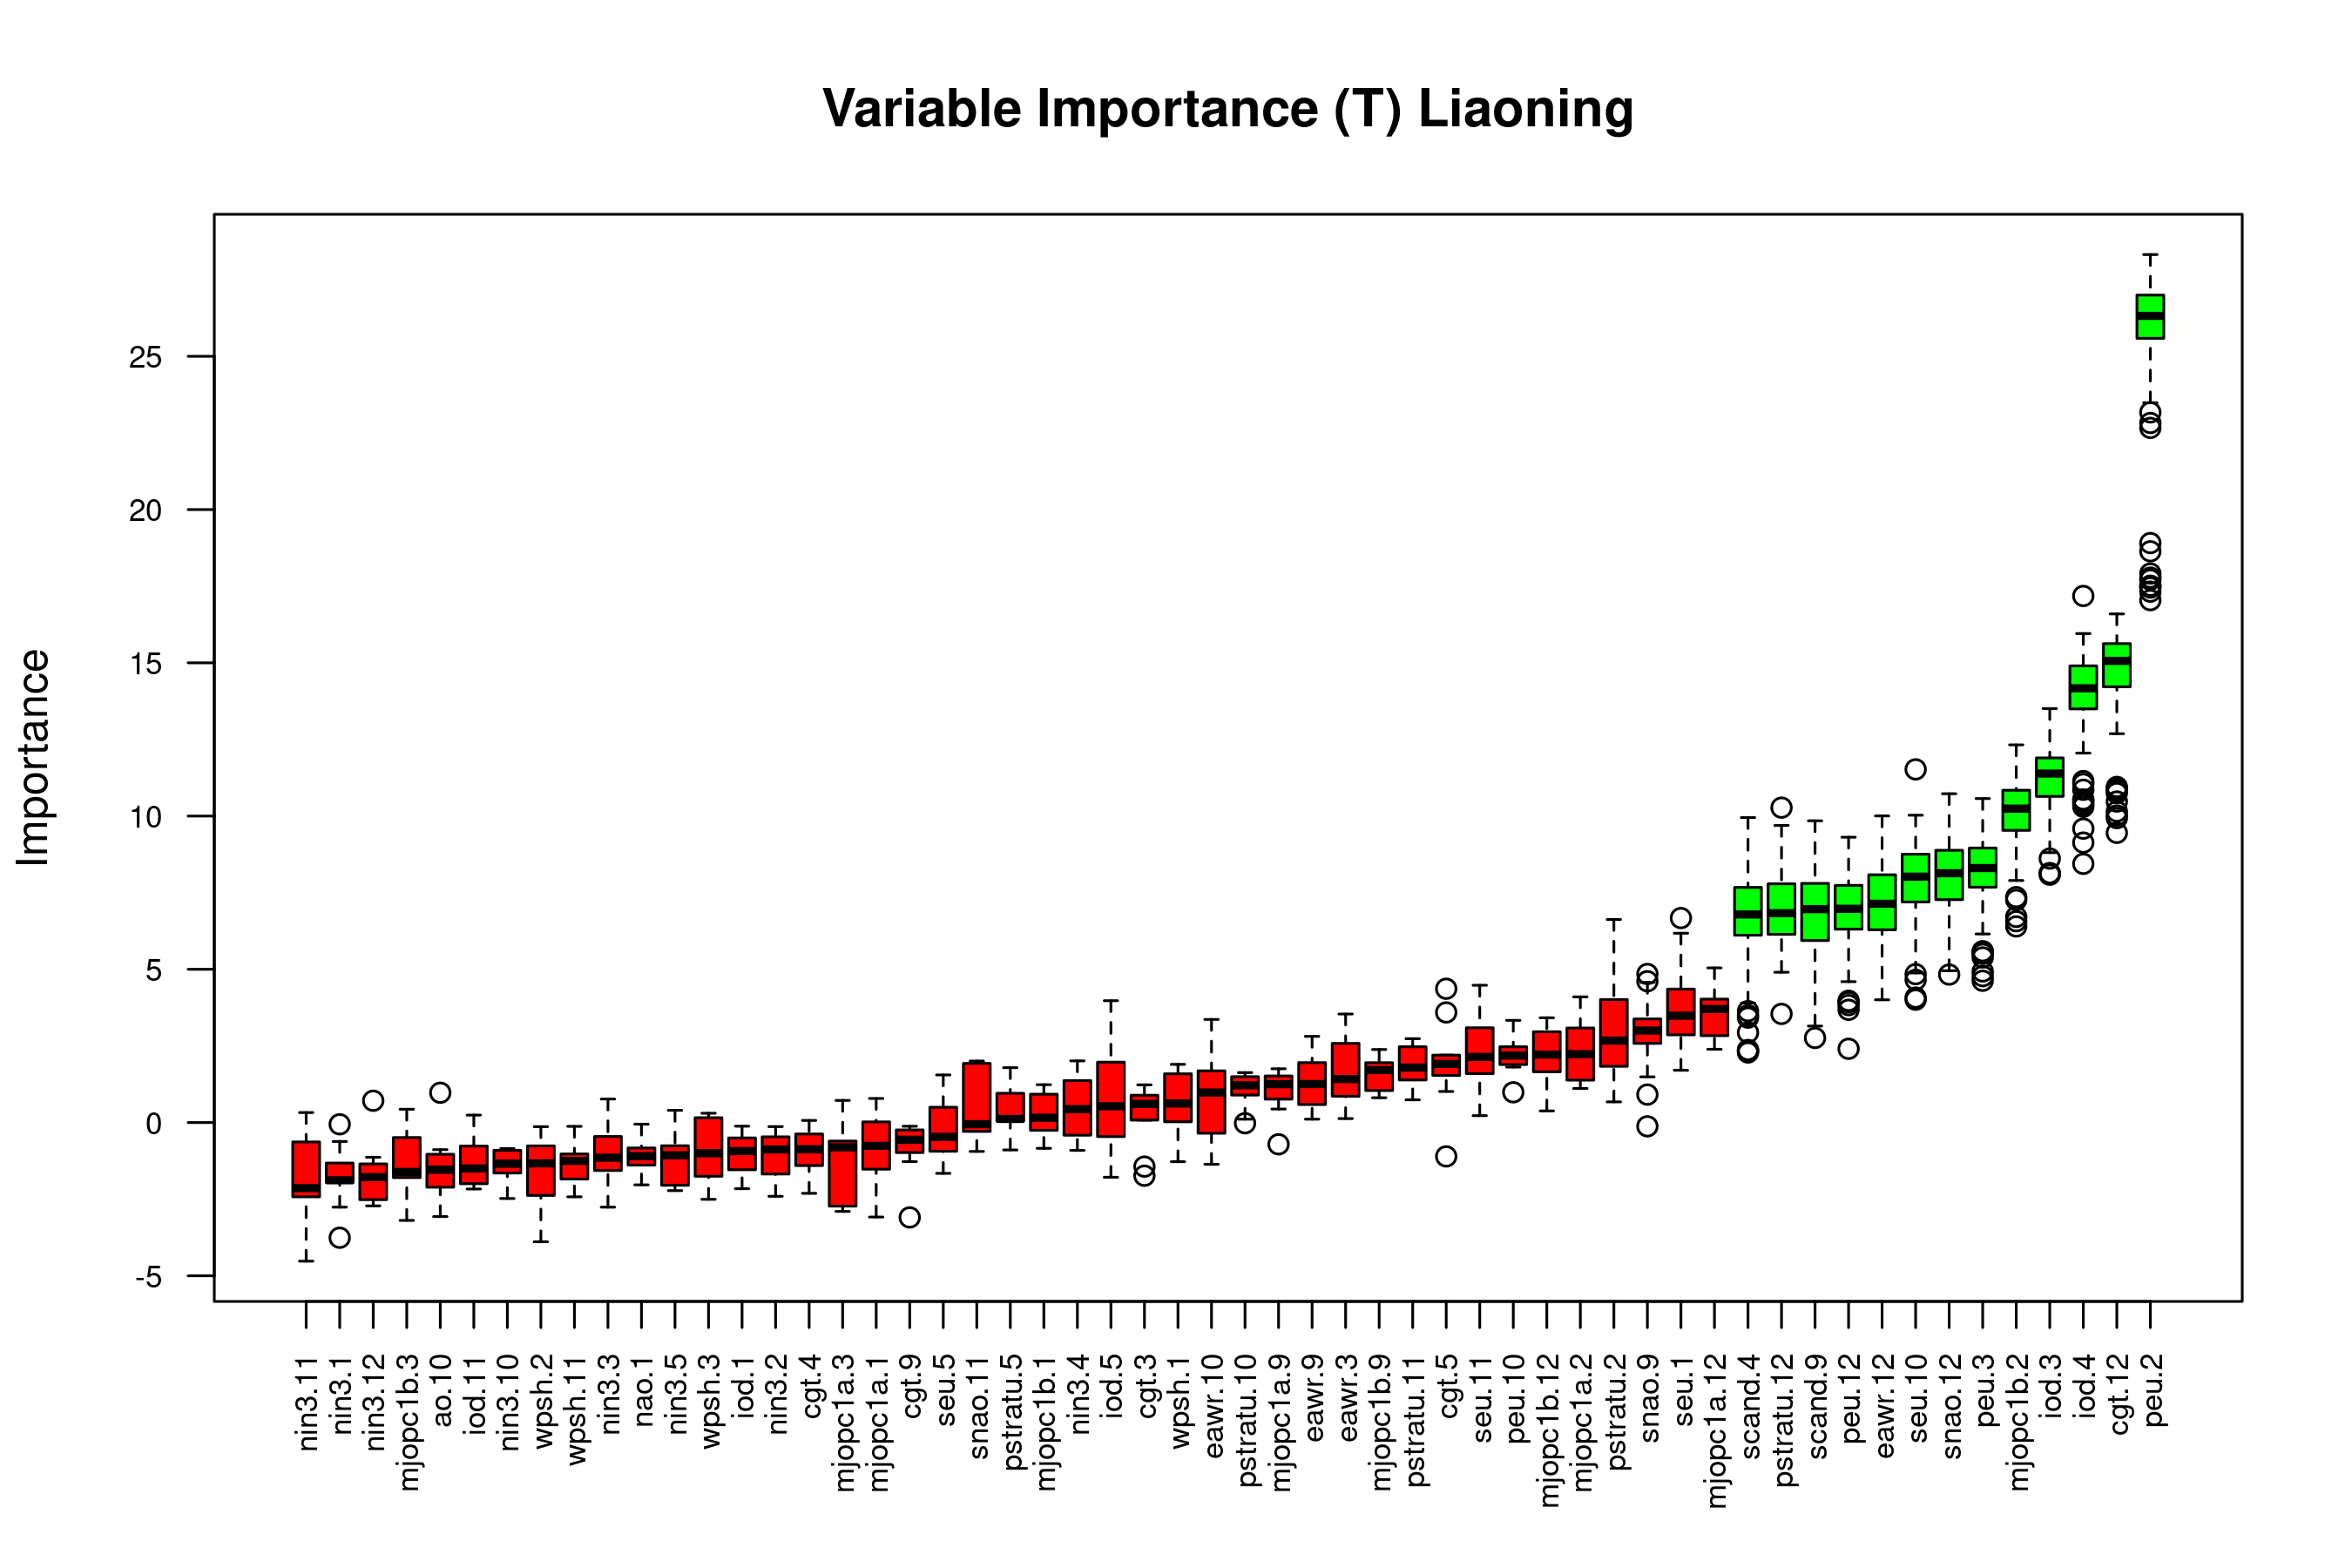

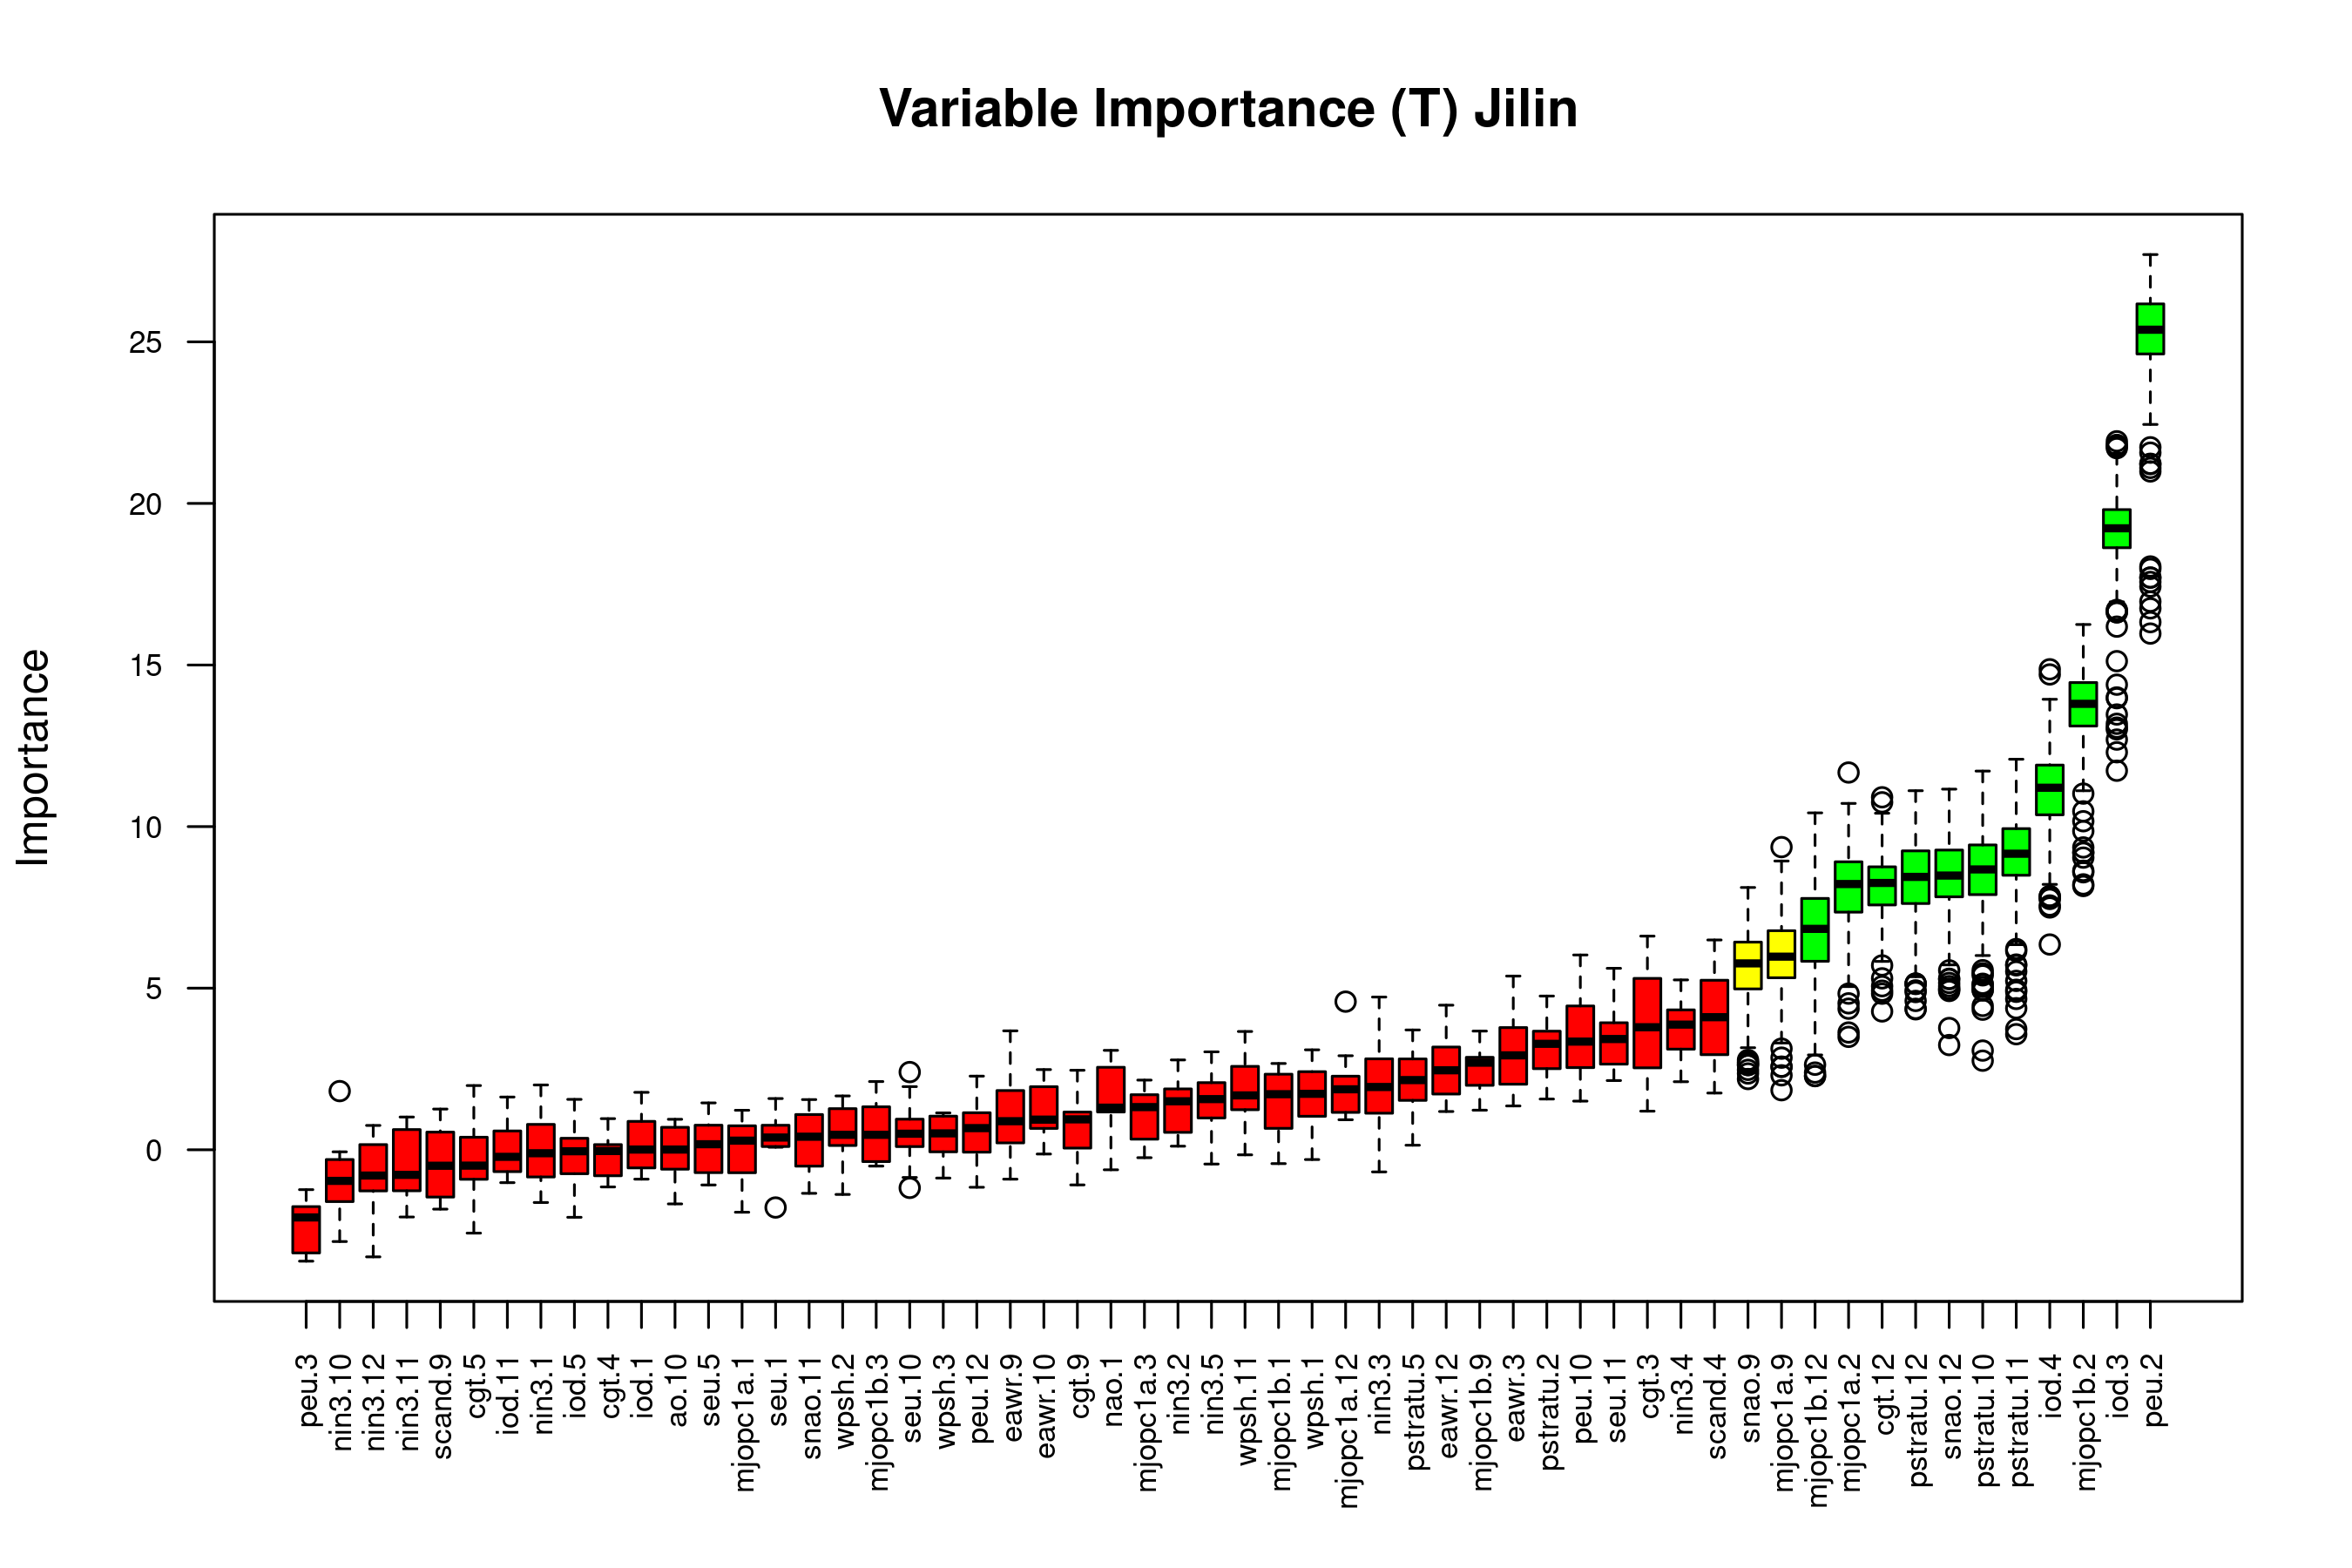

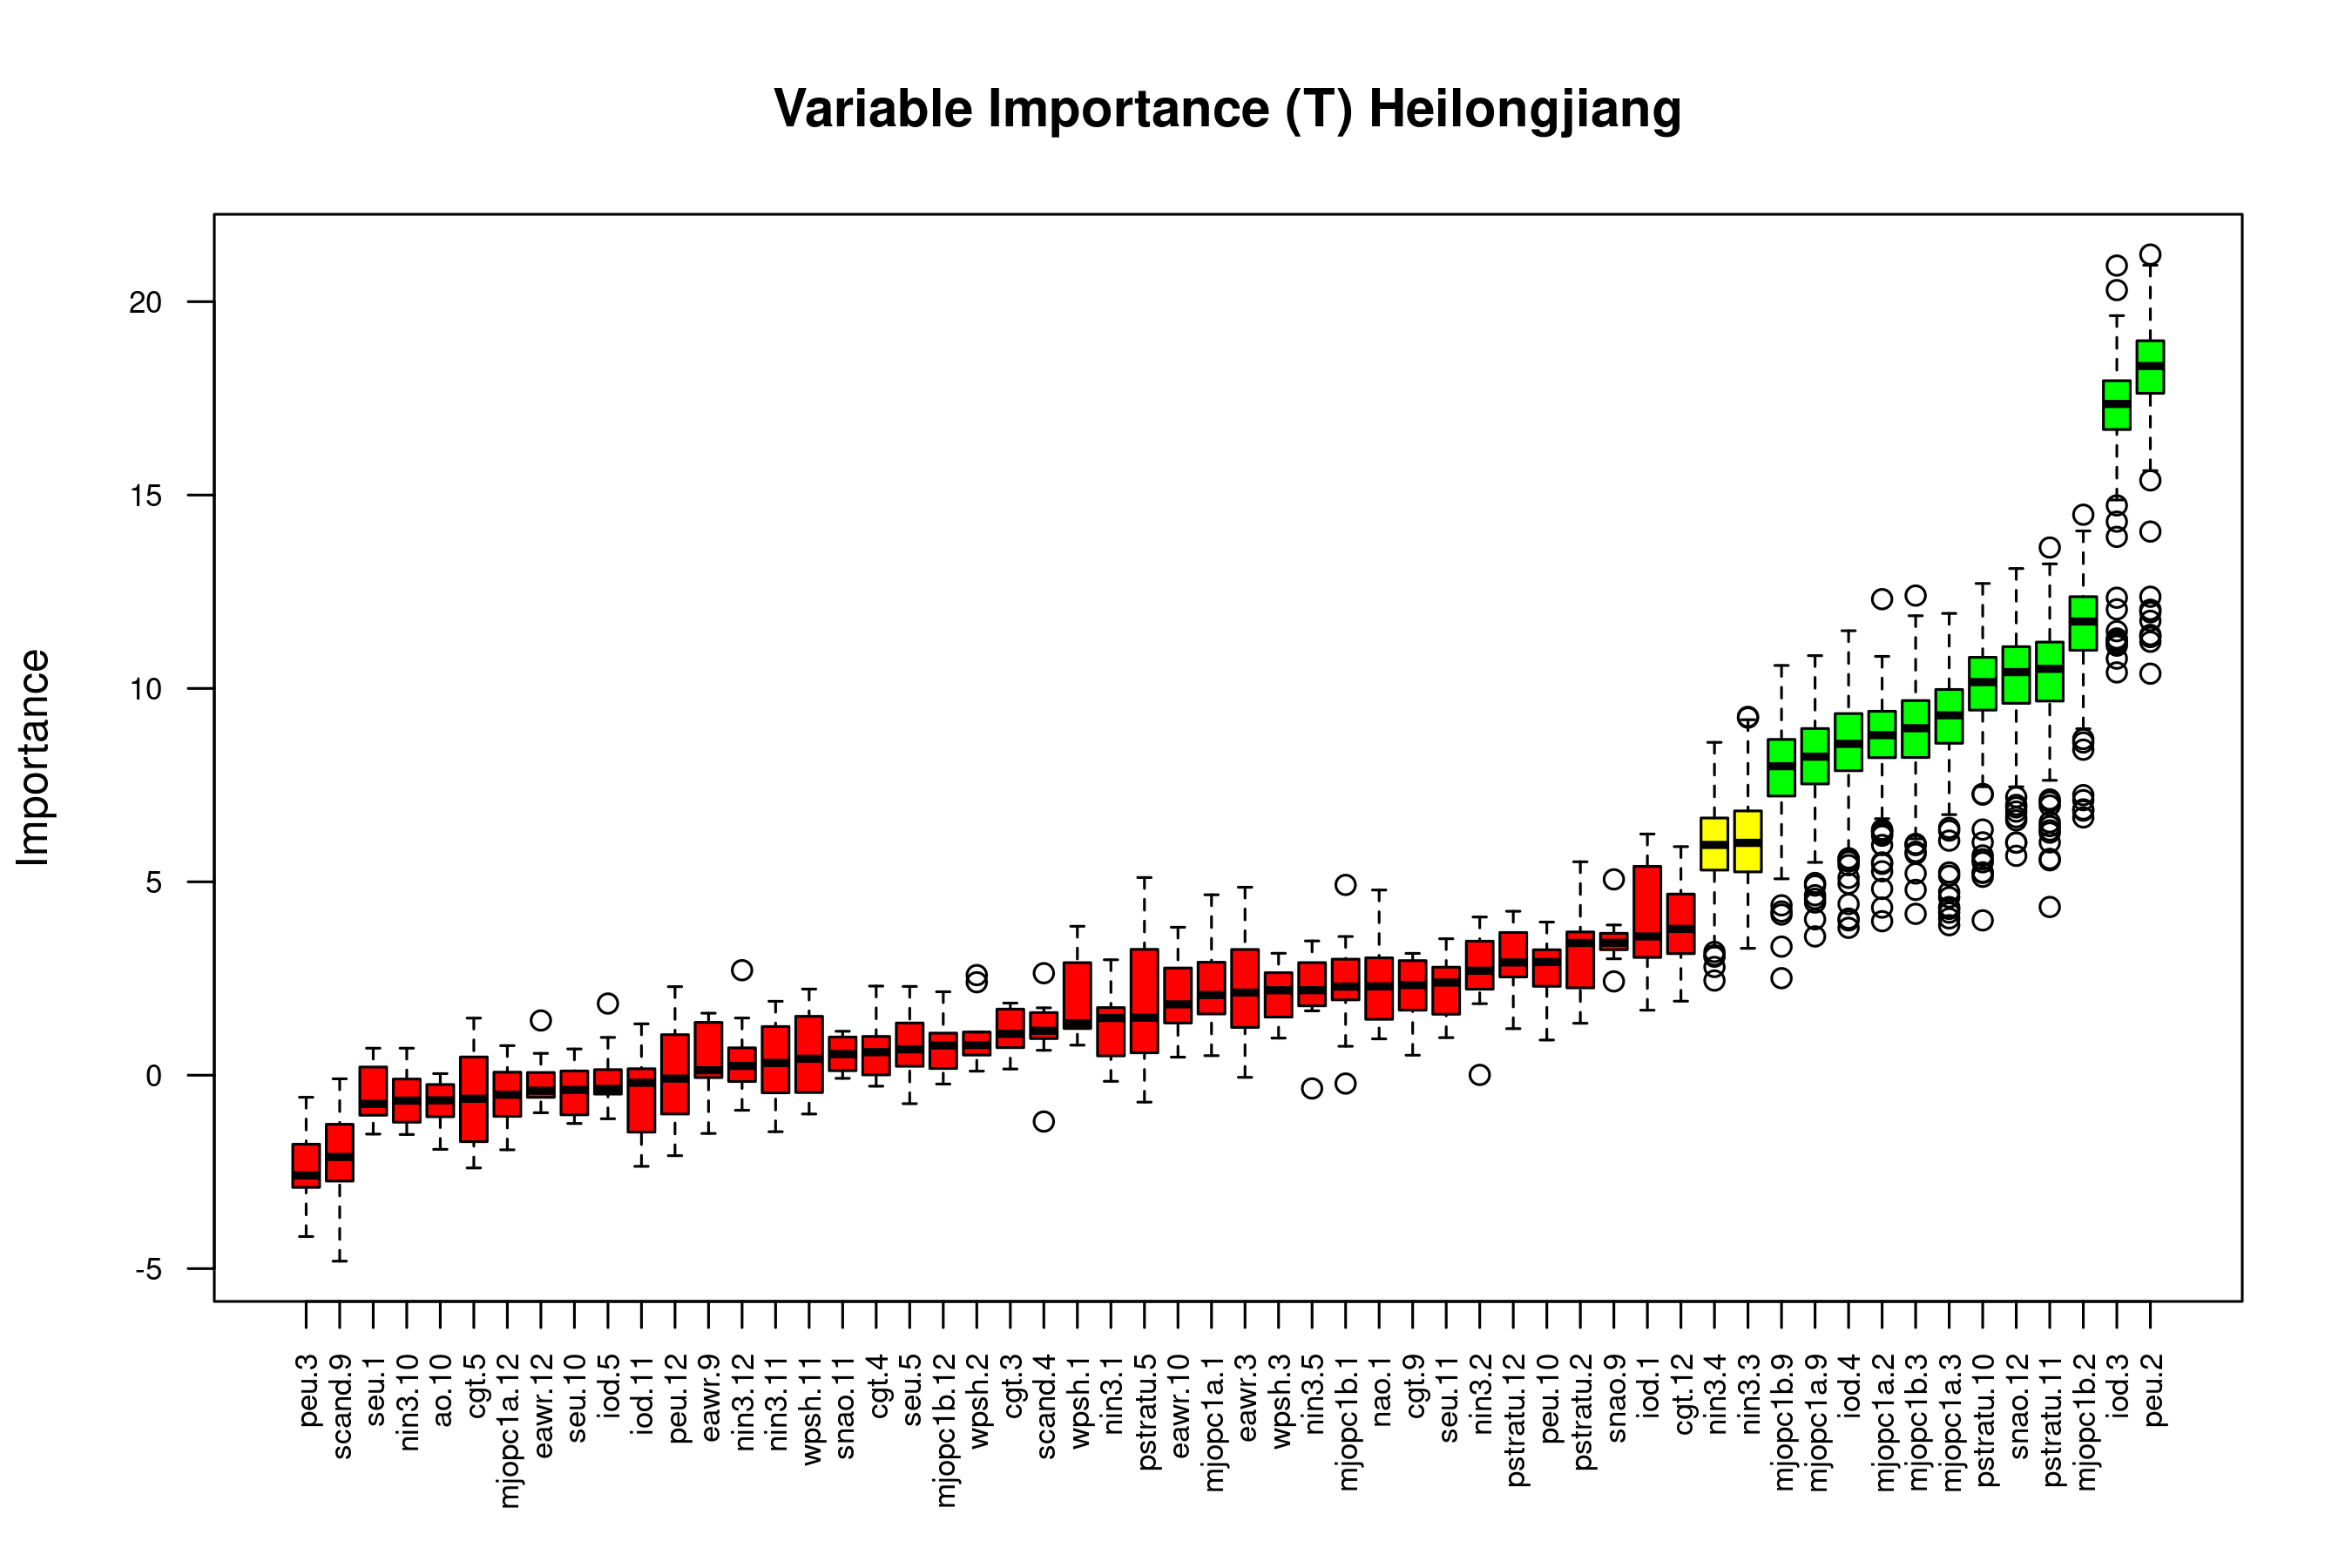

In [26]:
for (k in 1:length(provinces)) {
    fname = paste('./',region,'_varimp_',provinces[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")
    png(fname,width=9,height=6,units="in",res=300)
    plot(rf_cindex_results[[provinces[k]]], cex.axis=.7, las=2, xlab="", main=paste("Variable Importance (T)", provinces[k]), whichShadow = c(FALSE, FALSE, FALSE))  # plot variable  
    dev.off()
    display_png(file=fname, width=750)
    }

### Top 10 strongest predictors for temperature in each region
Make a barplot of the top ten predictors for each region, with their correlation coefficients

In [27]:
top10_correlations_df <- function(ind, k) {
    c_inds = order(-abs(ind[,k]))[1:10]
    c_names = row.names(ind)[order(-abs(ind[,1]))][1:10]
    c_df = data.frame(feature = c_names, importance = abs(ind[c_inds,k]))
    return(c_df)
}

In [28]:
plot_10_correlations <- function( df, region_name, filename) {
    ggplot(data = df) + 
    aes(x = reorder(feature, -importance), y = importance, fill = feature) +
    geom_bar(stat="identity") + 
    labs(x = "Features", y = "Correlation") +
    geom_text(aes(label = round(importance, 2)), vjust=1.6, color="white", size=4) + 
    theme_bw() + 
    theme(legend.position = "none") + 
    ggtitle(paste('Feature correlated with T', region_name))
    ggsave(filename, width=6, height=4)
}

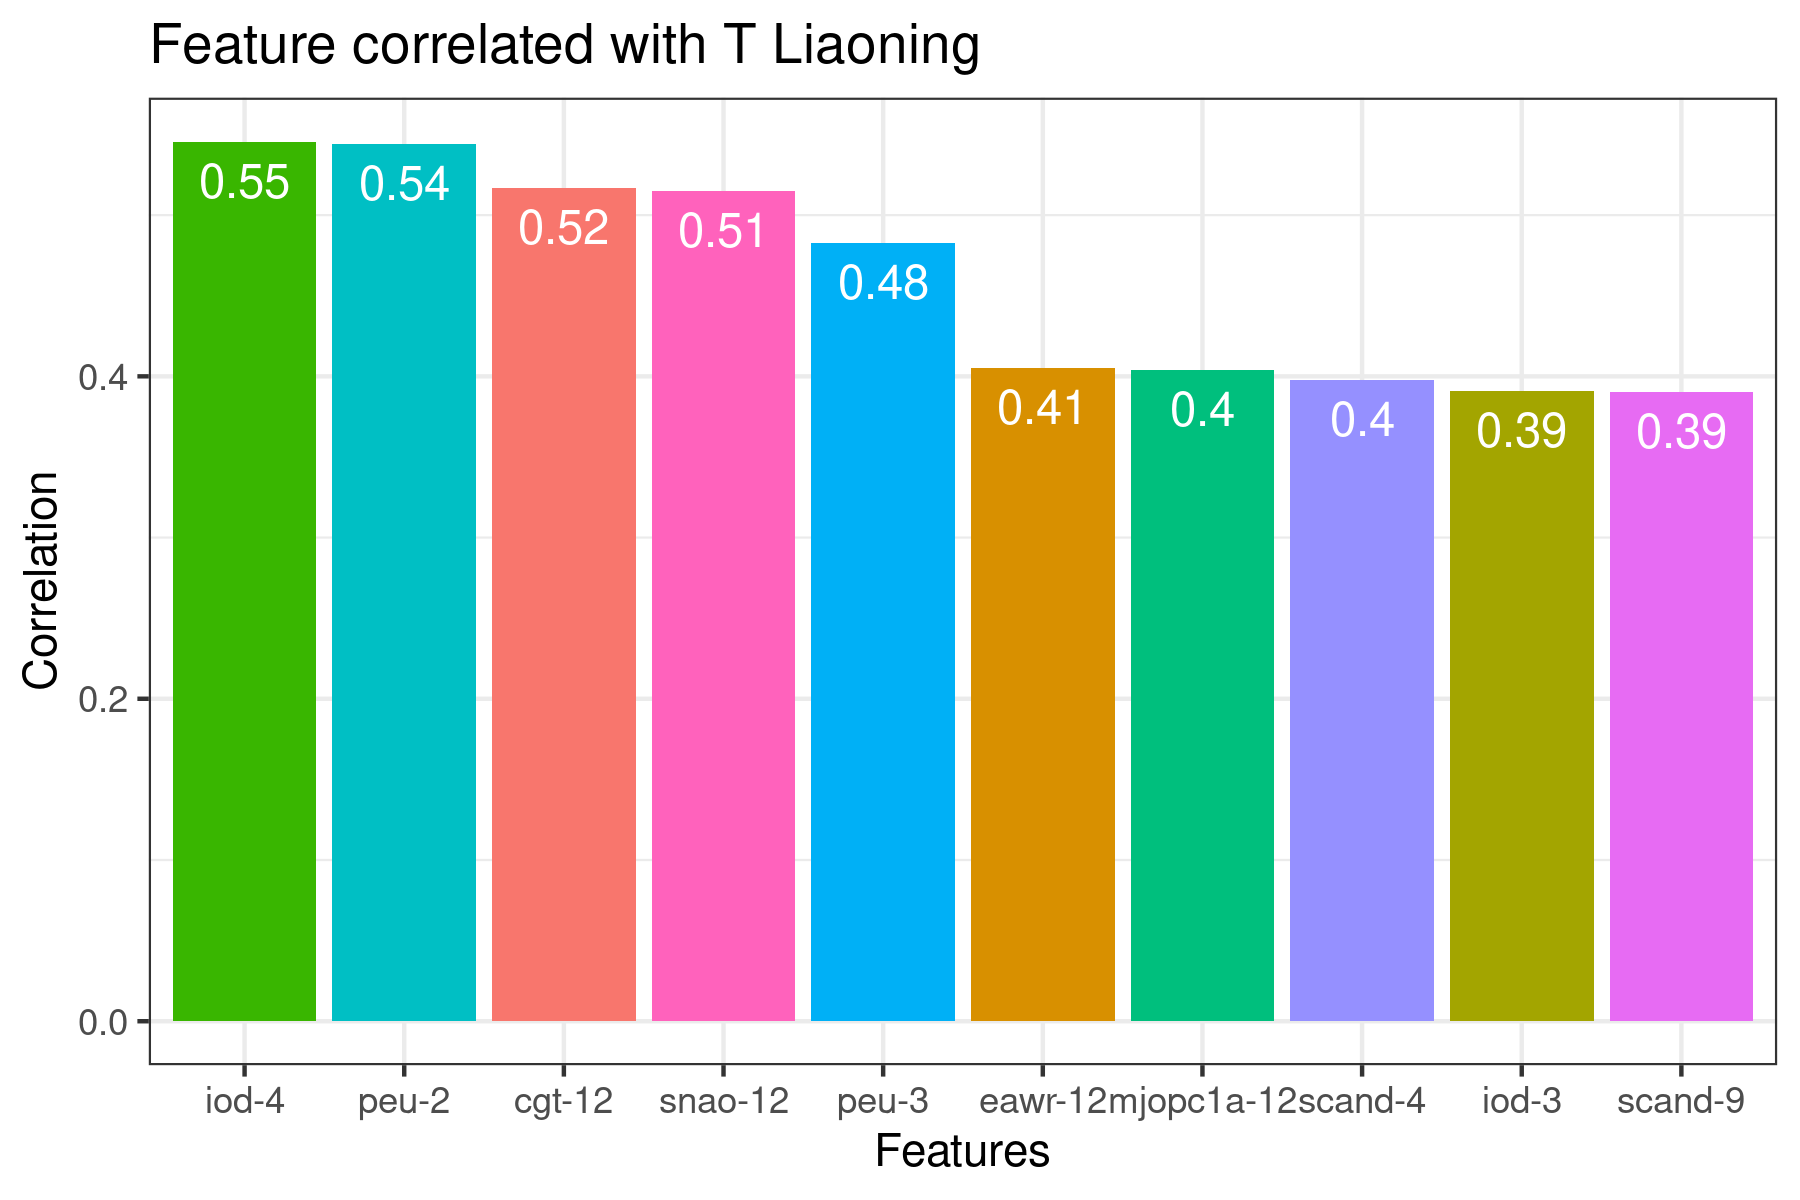

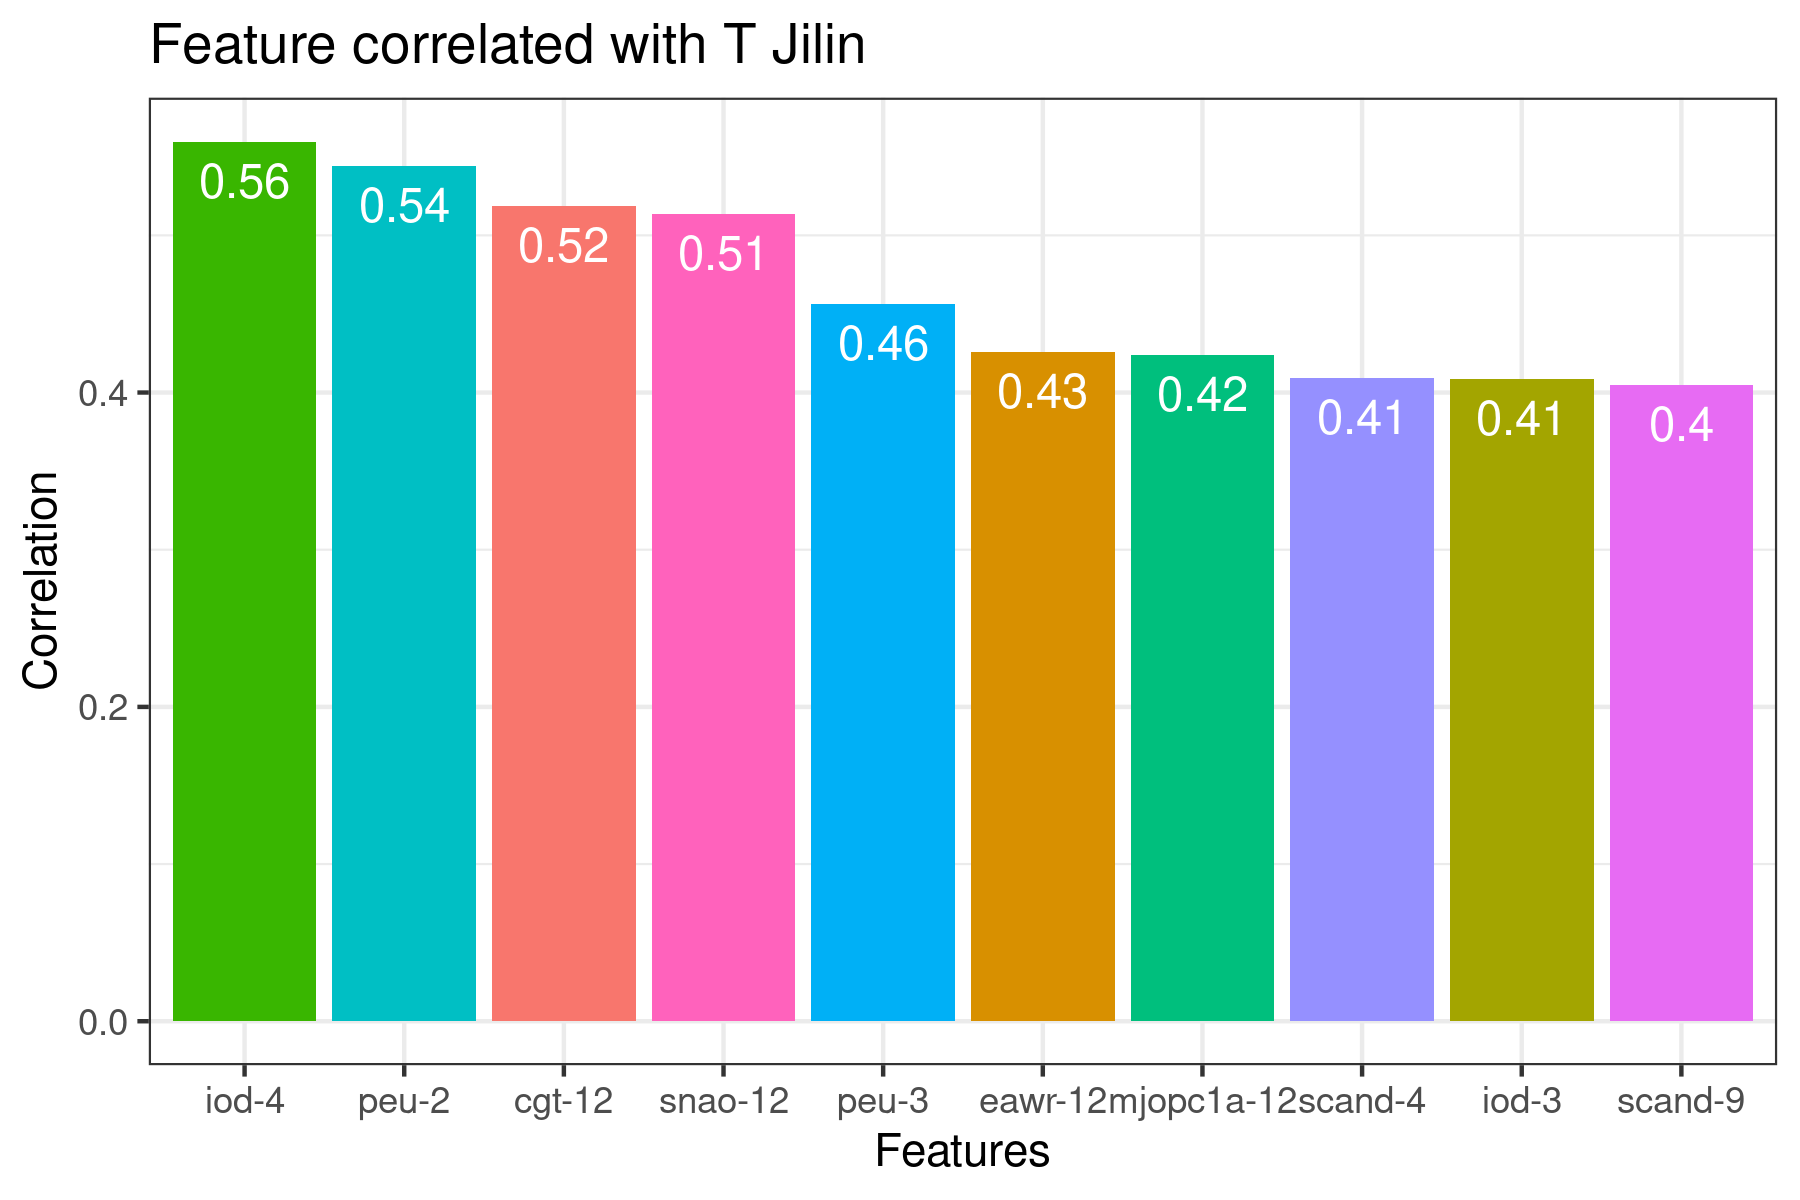

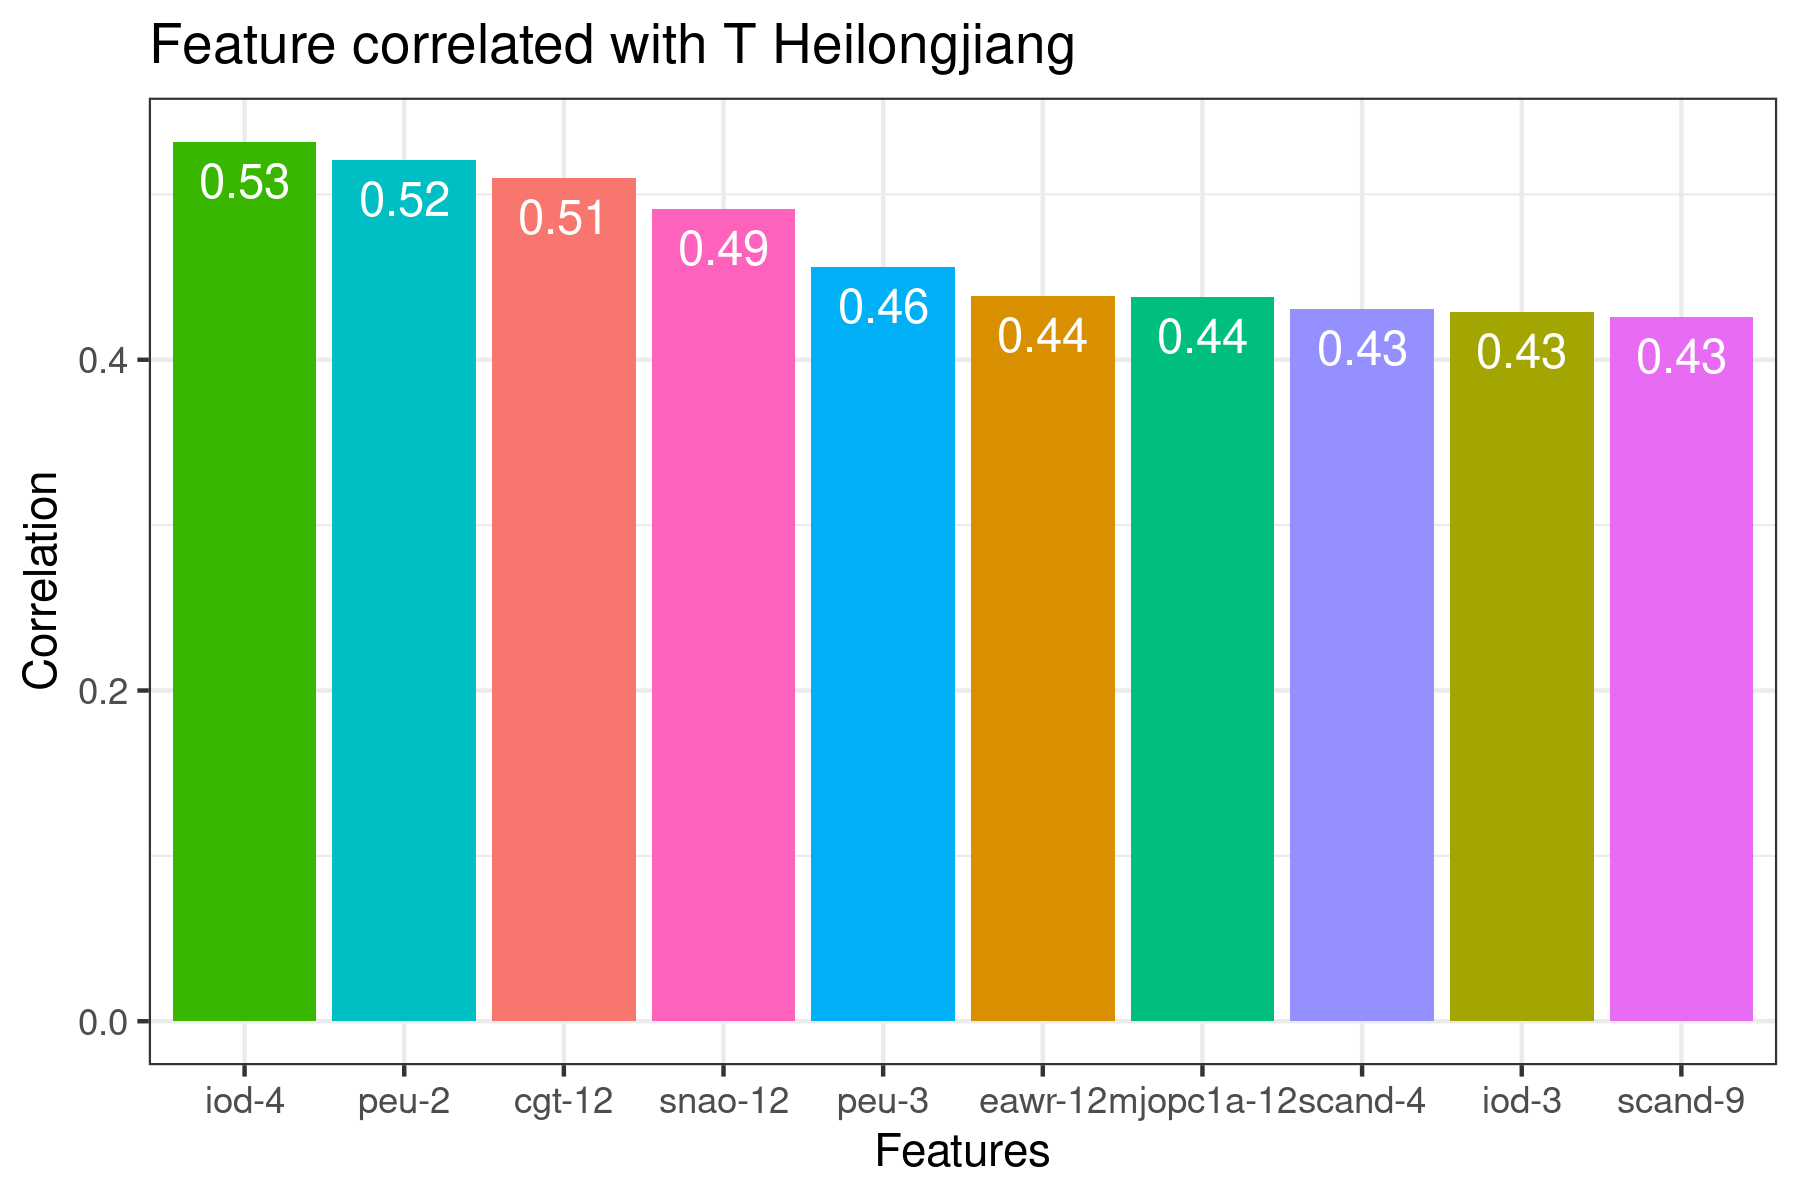

In [29]:
for (k in 1:length(provinces)) {
    fname = paste("./", region, "_corimp_temp_", provinces[k],".png", sep="") # filename to save figure to     
    t10_df = top10_correlations_df(cindex_temp_cors, k) # create dataframe of top 10 correlations 
    plot_10_correlations(t10_df, provinces[k] ,fname) # plot em 
    display_png(file=fname, width=750) # display the figure in the notebook
    }

### Selected predictors for each region
Generate a plot to display the predictors determined to be significant for each province. 
This allows us to check which predictors are good for predicting temperature across the whole NFR region.

In [30]:
# adjust width of plot in notebook
options(repr.plot.width=8, repr.plot.height=8)

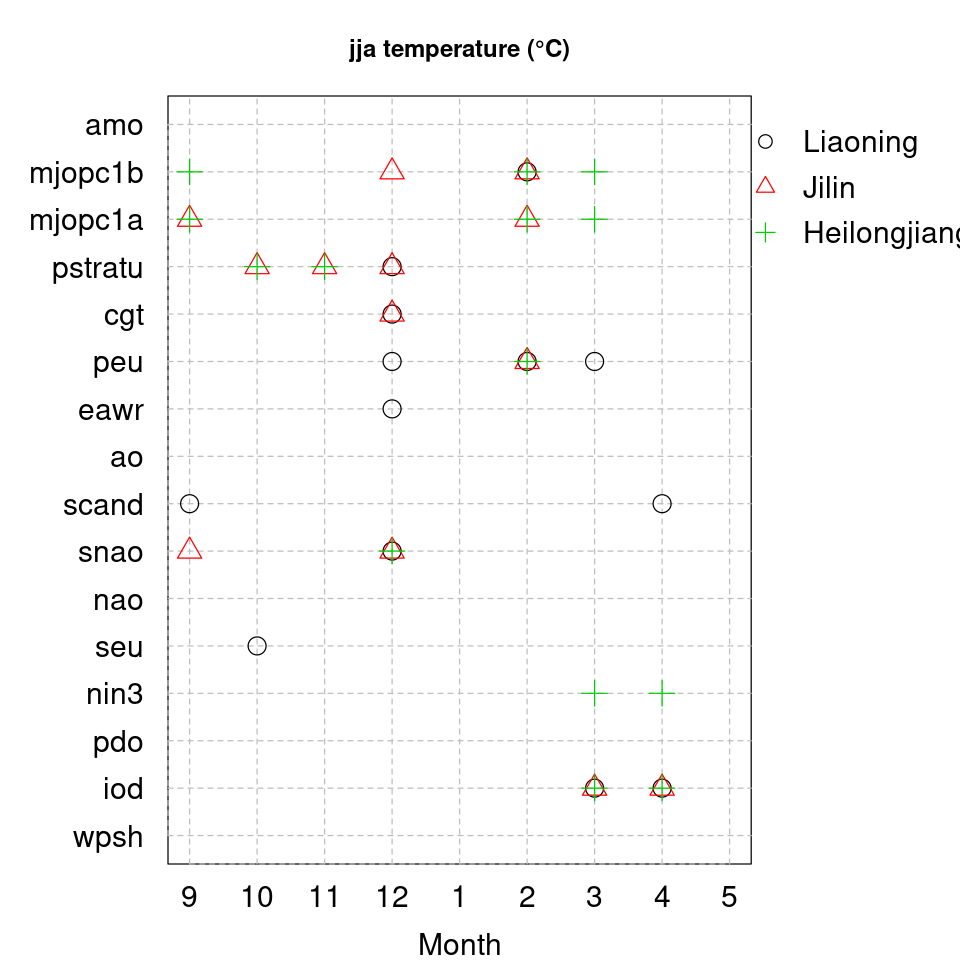

In [31]:
par(mfrow=c(1,1))
par(mar=c(4,7,4,8.7))
plot(NULL, xlim=c(1,length(cmons_num)), ylim=c(1,length(ind_list)), ylab="", xlab="Month", 
     main = paste(suffix," temperature (\u00B0C)",sep=""), xaxt="n", yaxt="n", cex.lab=1.5)
axis(1, at=1:length(cmons_num), labels=cmons_num,cex.axis=1.0, tck = 1, lty = 2, col = "grey", 
     cex.lab=1.5, cex.axis=1.5)
axis(2, at=1:length(ind_list), labels=ind_list,cex.axis=1.0, tck = 1, lty = 2, col = "grey", 
     cex.lab=1.5, cex.axis=1.5, las=1)

sub = 2:(length(colnames(cindex_anoms)) + 1)

for (k in 1:1:length(provinces)) {
    tinds = which(abs(coef_array_full[k,2,sub]) > 0.5)
    tnames = strsplit(names(tinds), split = "-")
    var_tind = numeric(0)
    mon_tind = numeric(0)
    
    for (i in 1:length(tinds)) {
    var_tind[i] = which(tnames[[i]][1] == ind_list)
    mon_tind[i] = which(as.numeric(tnames[[i]][2]) == cmons_num)
    }
    
    points(mon_tind, var_tind, pch=k, col=k, cex=2)
}

legend("topright", legend = provinces,bty = "n",
       pch = 1:length(provinces), col=1:length(provinces), 
       cex=1.5, xpd = TRUE, inset = c(-0.51, 0))

### Feature selection of East Asian subtropical and polar jets
Run the same feature importance analysis for the u- and v-wind jet indices.

In [32]:
x_train = jet_anoms
rf_jet_results = list()

dx2 = 1+dim(jet_anoms)[2]
coef_jarray_full = array(0, c(length(provinces),4,dx2))
dimnames(coef_jarray_full)[[3]] <- c("Intercept", colnames(jet_anoms))
dimnames(coef_jarray_full)[[1]] <- provinces

In [33]:
for (k in 1:length(provinces)) {
    set.seed(1)
    y_train = temp_anoms[,k]
    df_in  = data.frame(cbind(x_train, y_train))
    boruta_output <- Boruta(y_train ~ ., data=df_in, doTrace=0, maxRuns= 200, ntree=2000, pValue = 0.1)  # perform Boruta search
    boruta_signif <- names(boruta_output$finalDecision[boruta_output$finalDecision %in% c("Confirmed", "Tentative")])  # collect Confirmed and Tentative variables
    tvars = gsub("[[:punct:]]", "-", boruta_signif)
    coef_jarray_full[k,2,tvars] = 1
    rf_jet_results[[provinces[k]]] = boruta_output
}

In [34]:
rf_jet_results

$Liaoning
Boruta performed 52 iterations in 2.770161 secs.
 6 attributes confirmed important: eapju.6, eapju.8, eapjv.6, easju.6,
easju.7 and 1 more;
 18 attributes confirmed unimportant: eapju.3, eapju.4, eapju.5,
eapju.7, eapjv.3 and 13 more;

$Jilin
Boruta performed 199 iterations in 10.62862 secs.
 5 attributes confirmed important: eapju.6, eapju.8, eapjv.6, easju.6,
easju.7;
 18 attributes confirmed unimportant: eapju.3, eapju.4, eapju.5,
eapju.7, eapjv.3 and 13 more;
 1 tentative attributes left: easju.8;

$Heilongjiang
Boruta performed 199 iterations in 10.05007 secs.
 6 attributes confirmed important: eapju.6, eapju.8, eapjv.6, easju.6,
easju.7 and 1 more;
 15 attributes confirmed unimportant: eapju.3, eapju.4, eapju.5,
eapju.7, eapjv.3 and 10 more;
 3 tentative attributes left: eapjv.4, eapjv.7, easjv.5;


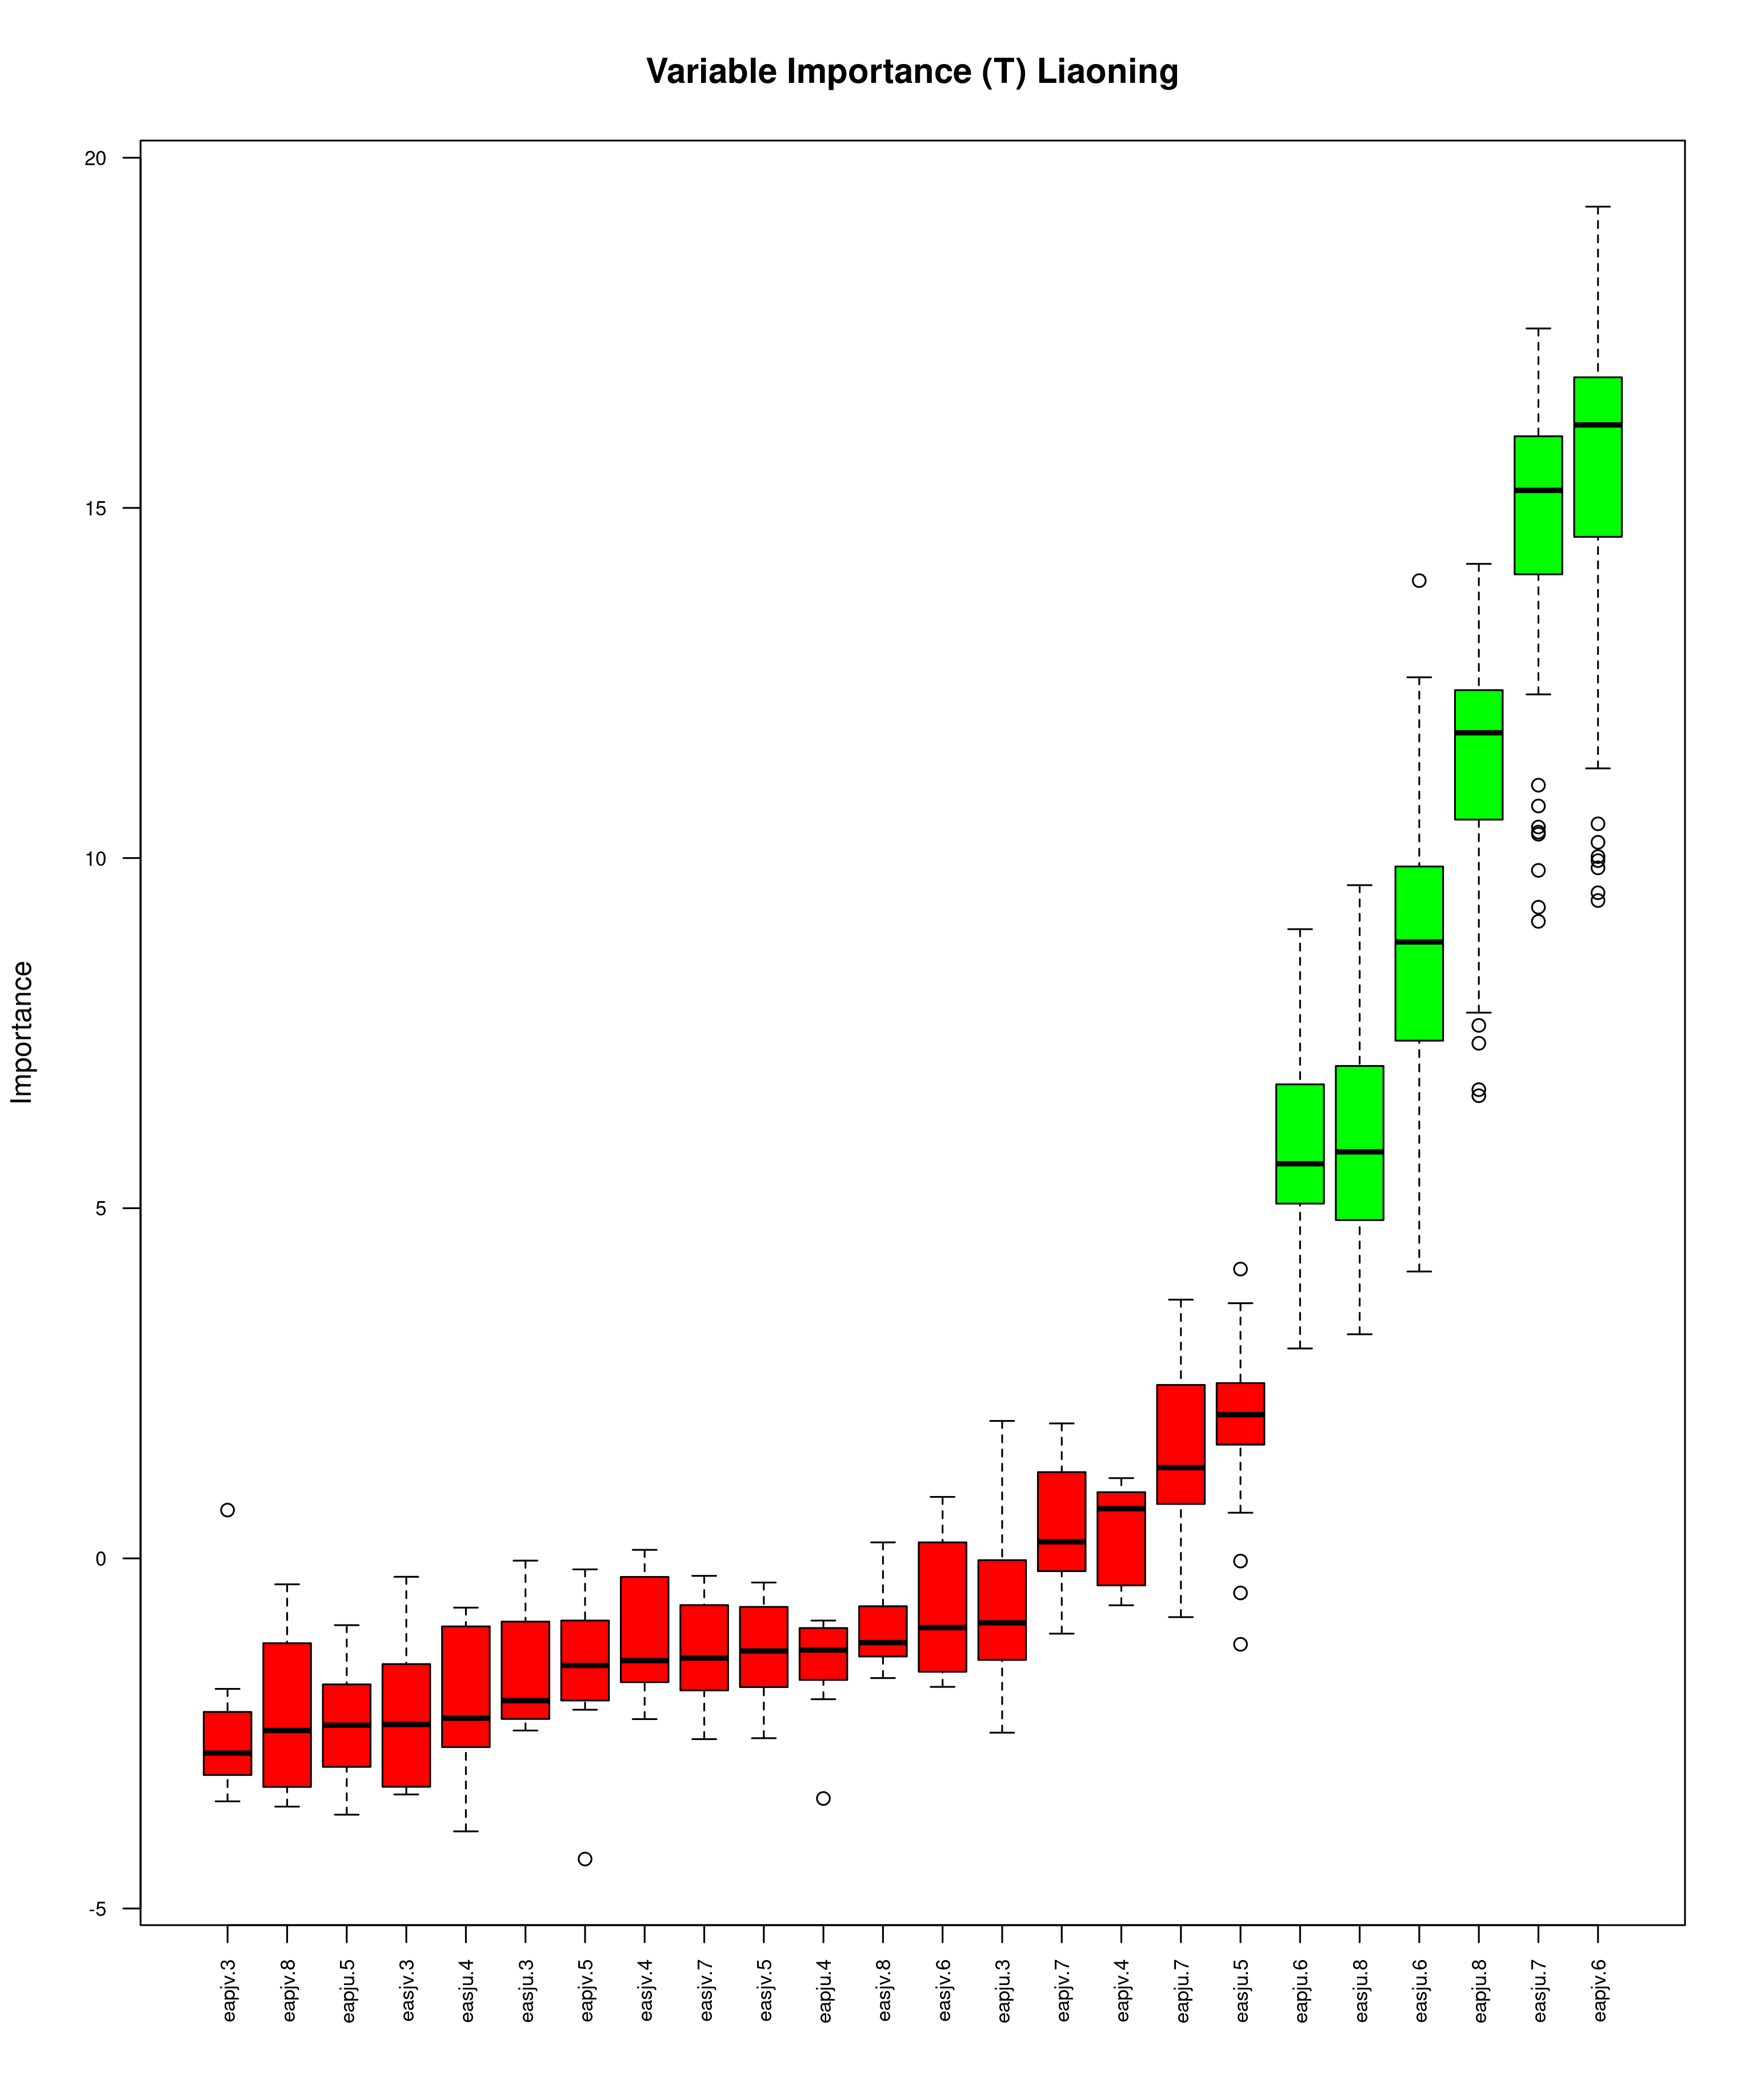

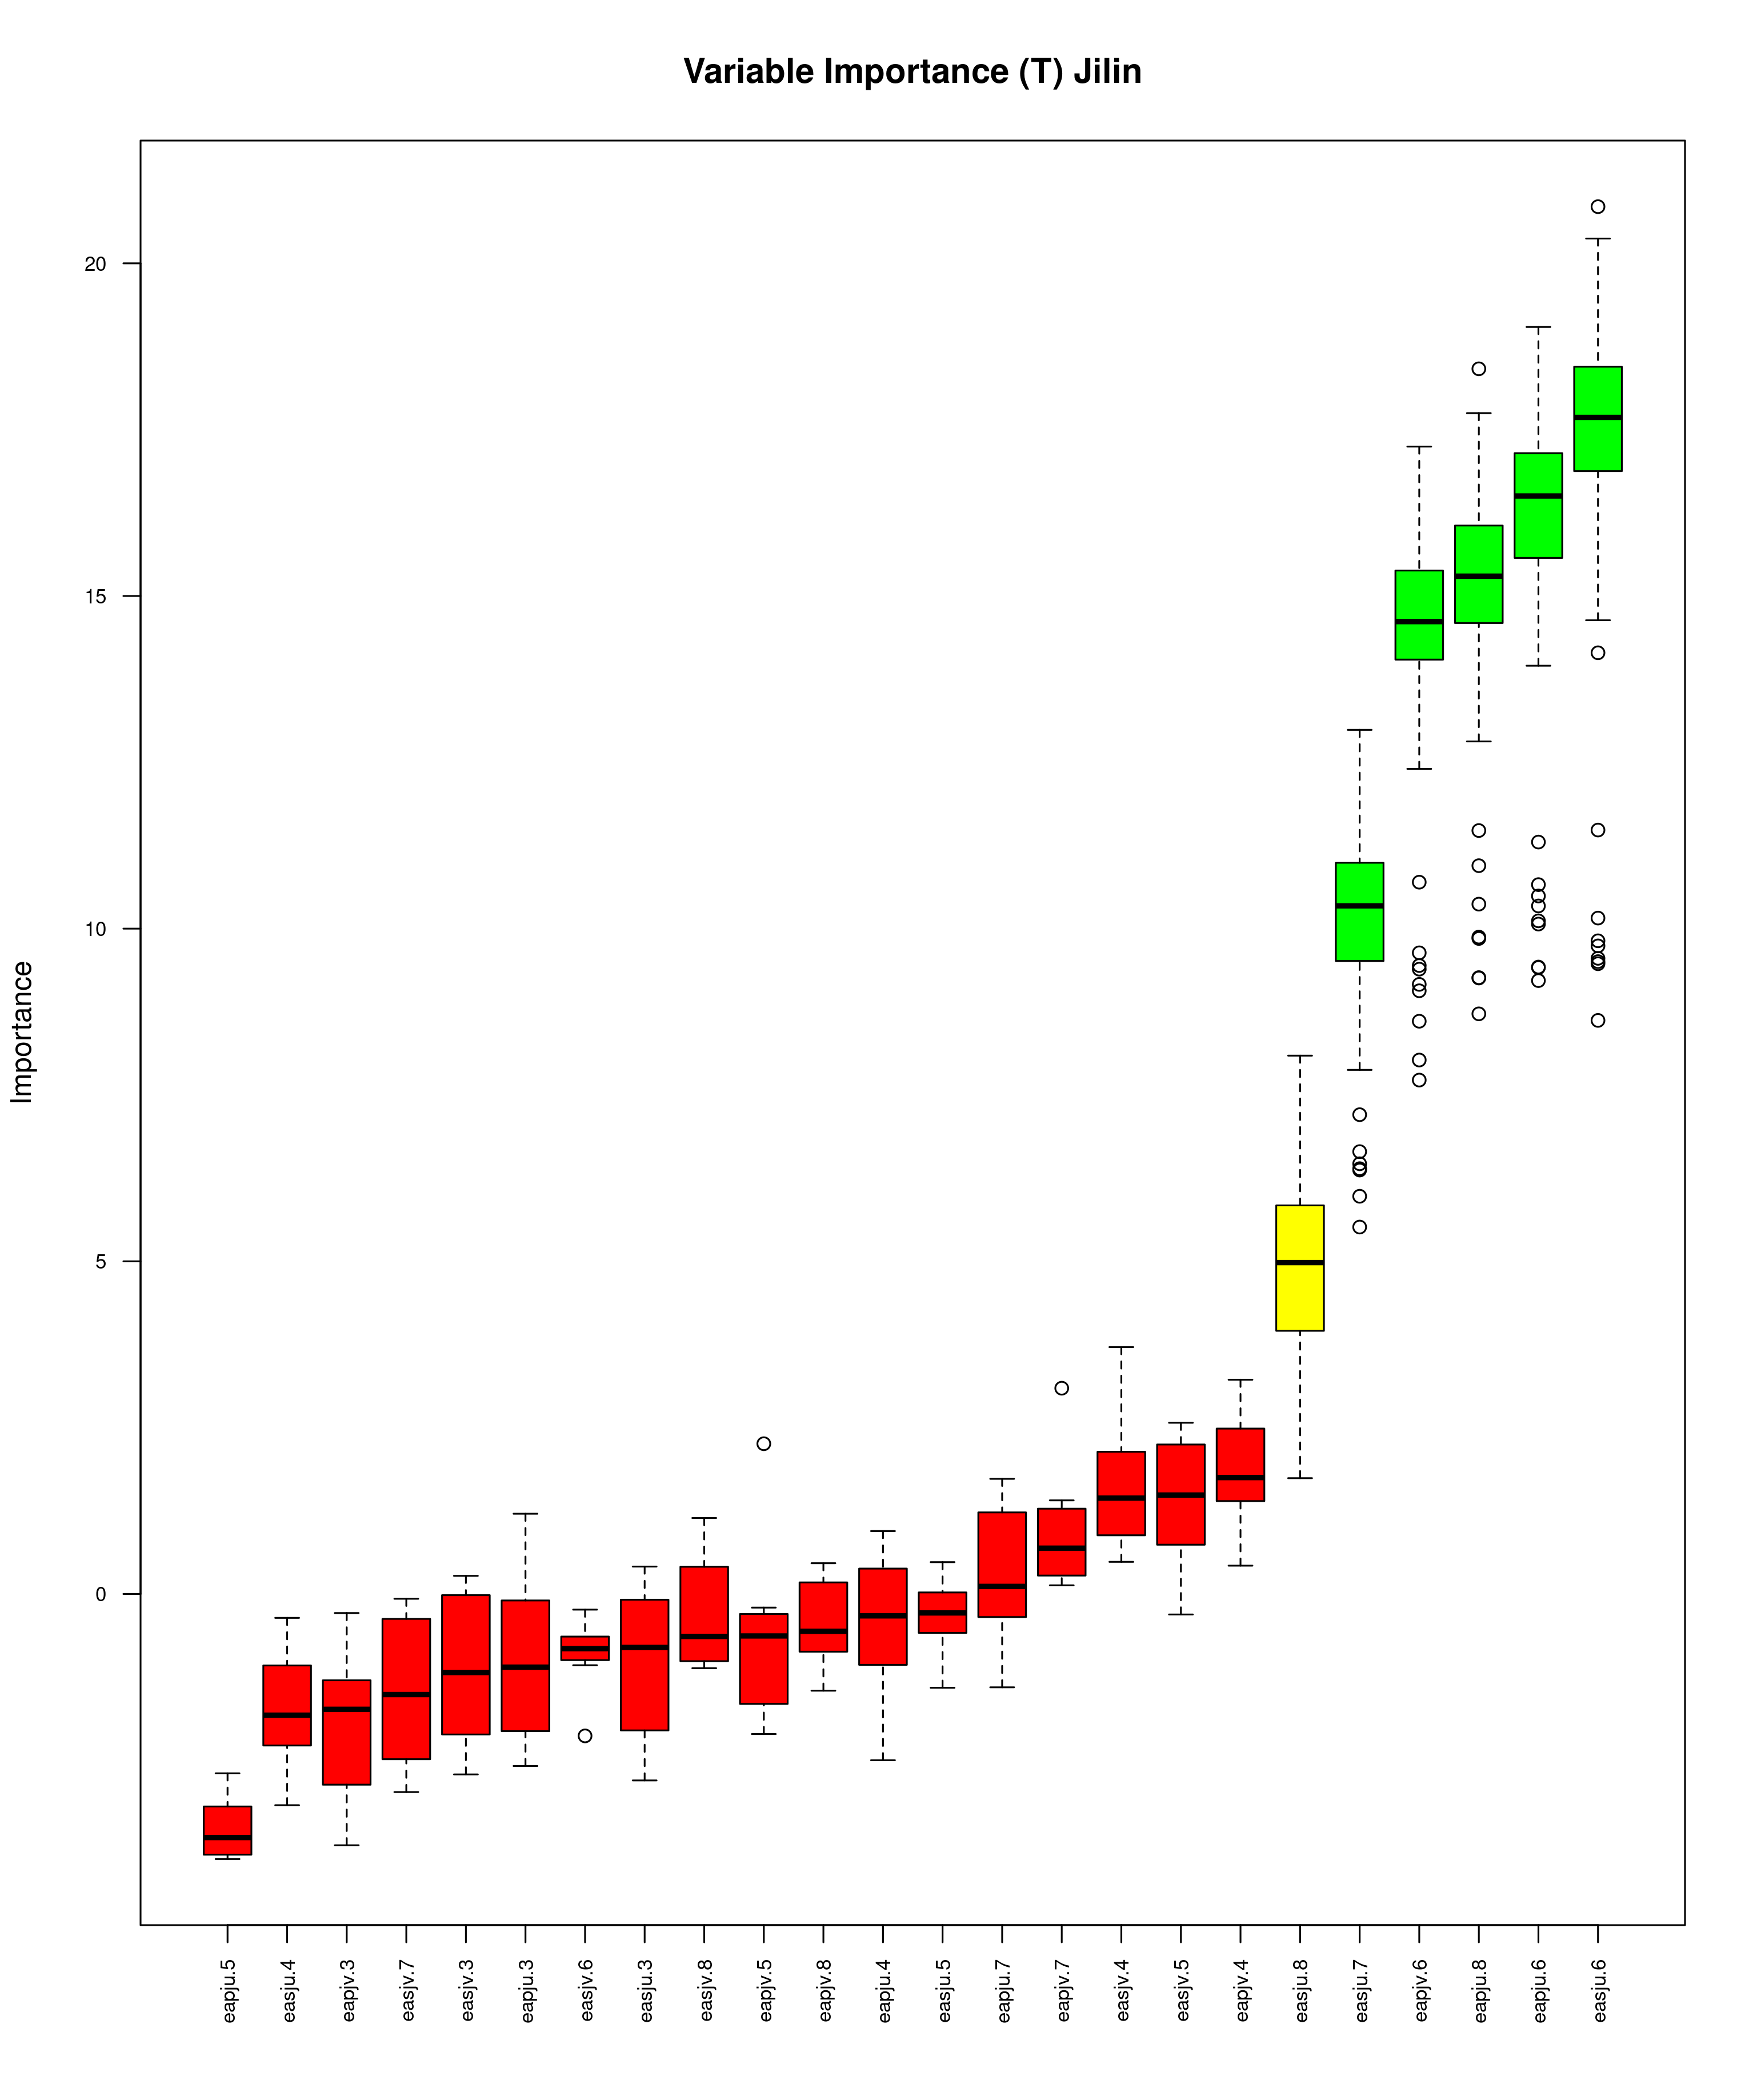

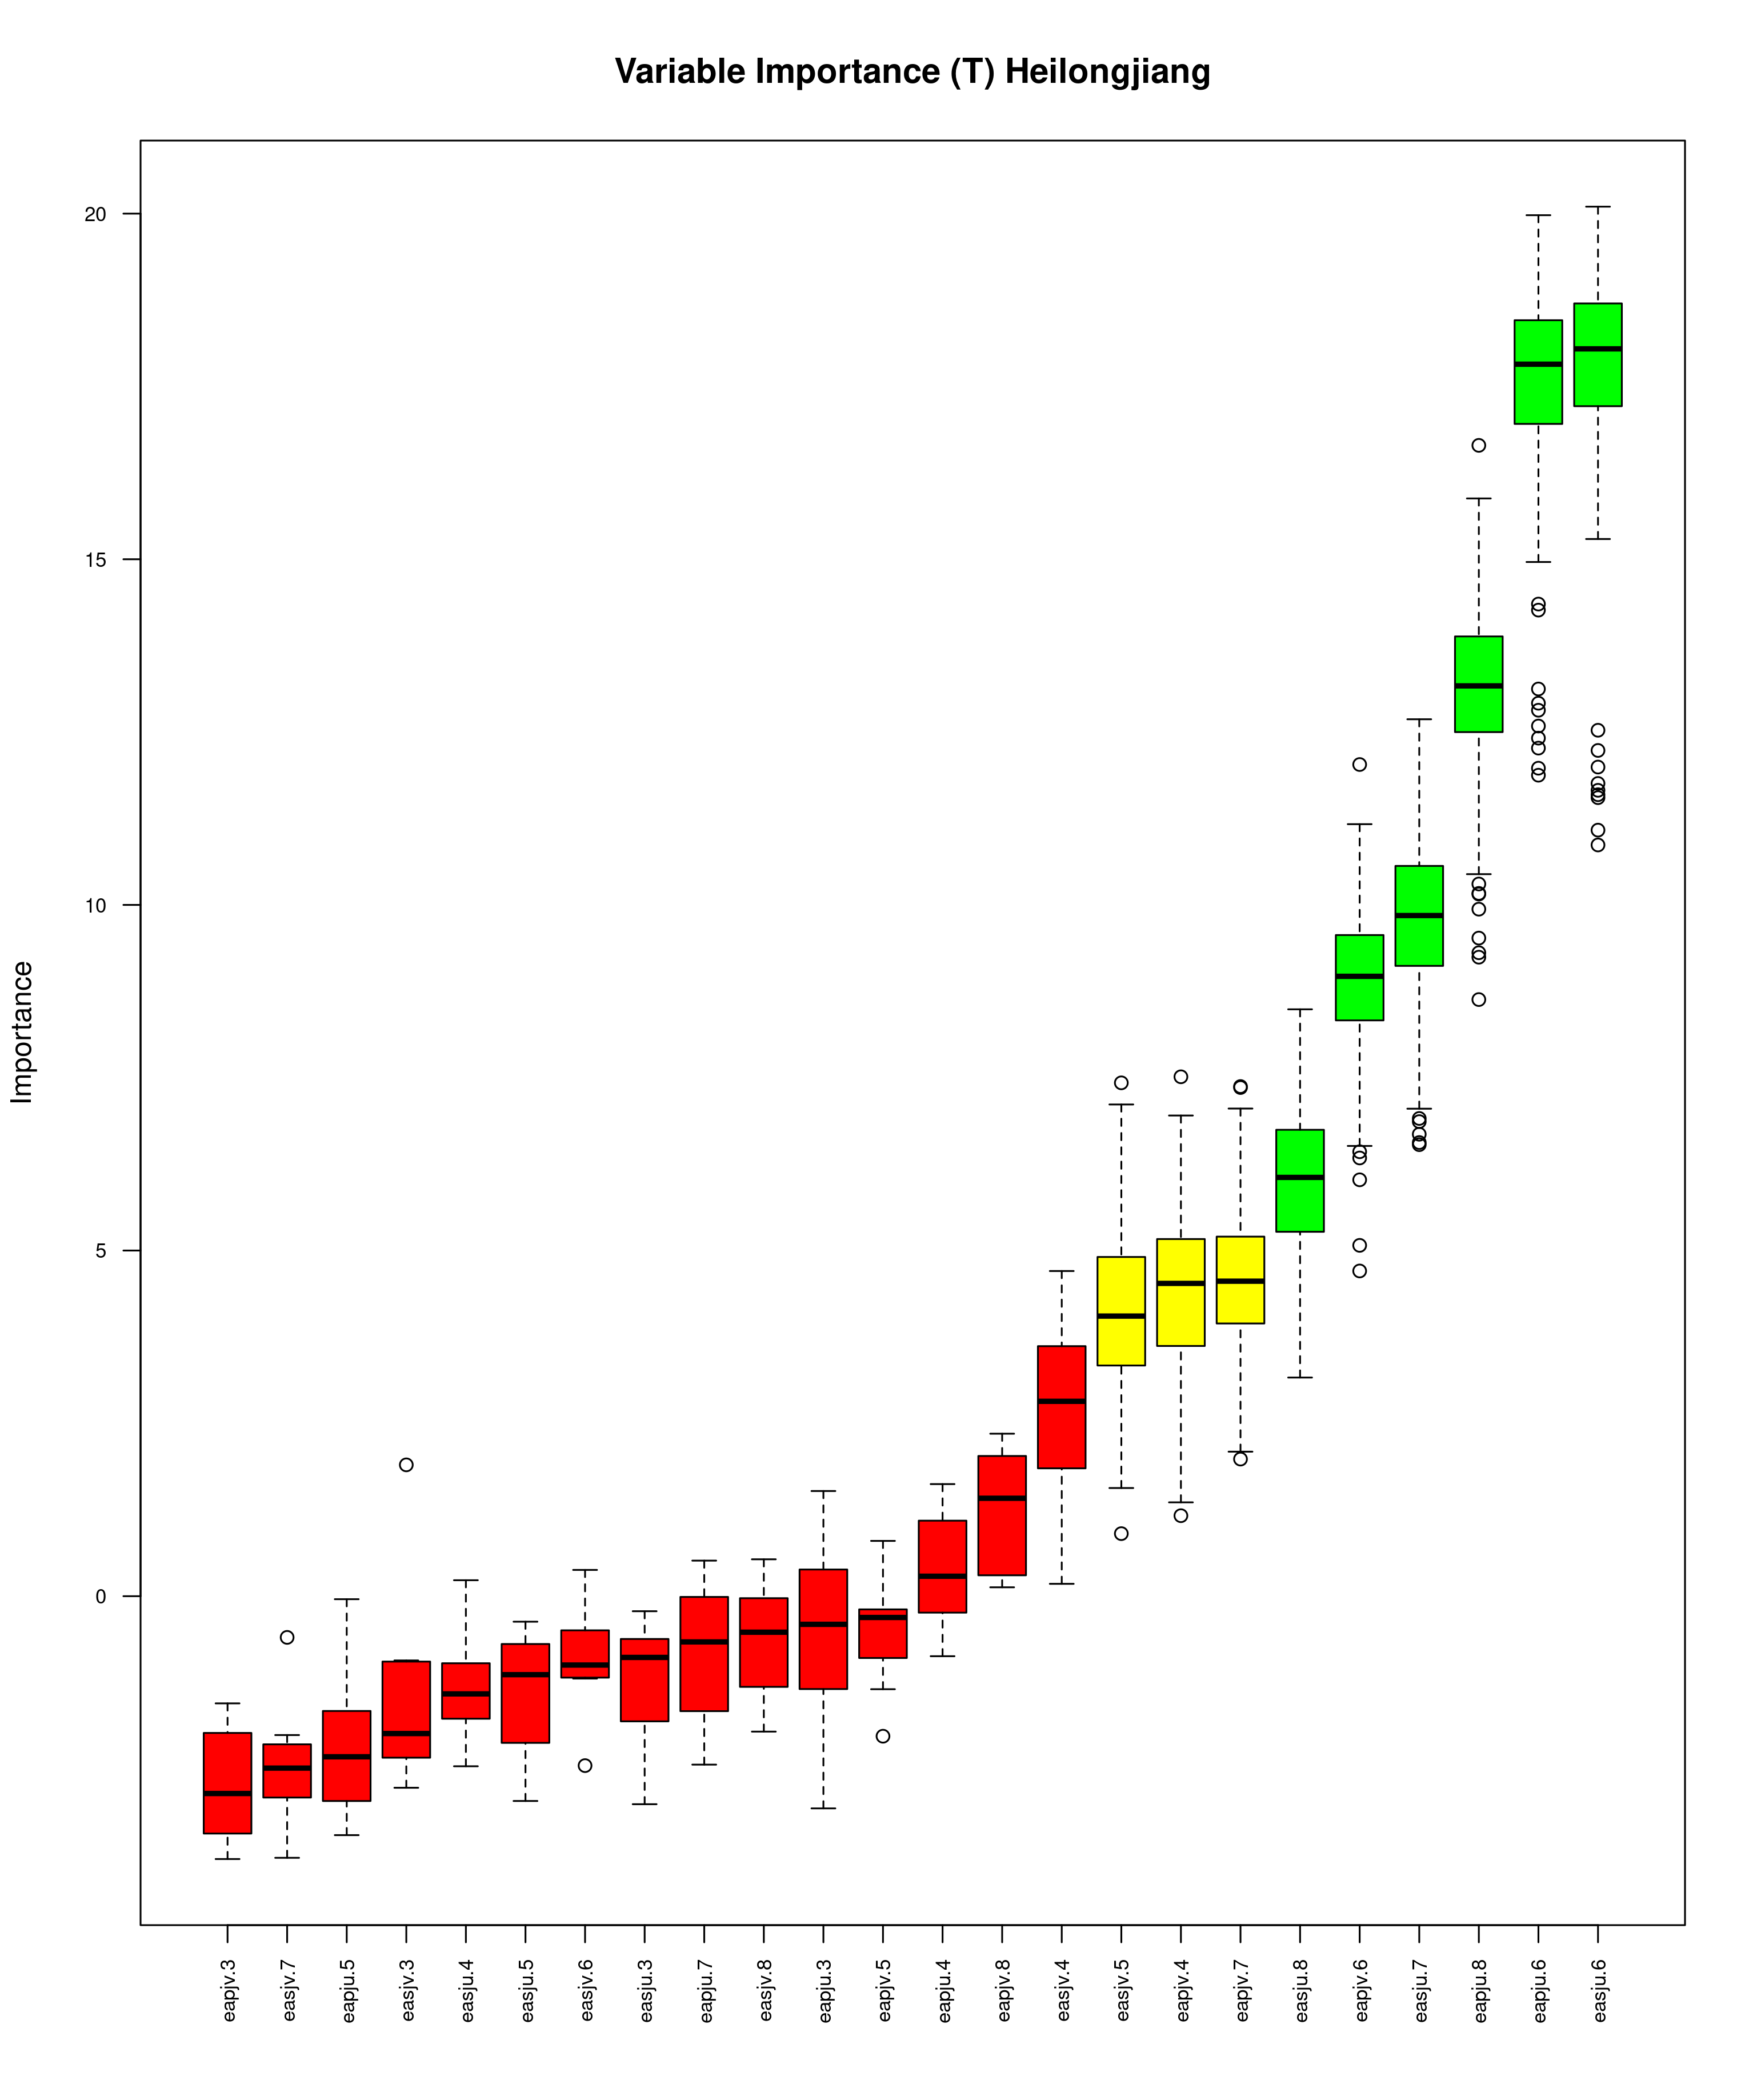

In [35]:
for (k in 1:length(provinces)) {
    fname = paste('./china_maize_jet_varimp_',provinces[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")
    png(fname,width=10.25,height=12.25,units="in",res=300)
    plot(rf_jet_results[[provinces[k]]], cex.axis=.7, las=2, xlab="", main=paste("Variable Importance (T)", provinces[k]), whichShadow = c(FALSE, FALSE, FALSE))
    dev.off()
    display_png(file=fname, width=750) 
}

<a id='section_4'></a>
## Section 4: Feature refinement  
* Creating Bayseian network of selected jet and climate indices and their links to provincial temperatures

In principle, we could explore the relationships between the selected variables and
 province temperatures by constructing undirected graphs from either a correlation or
 partial correlation matrix. However, these networks can be misleading as we cannot
 effectively control for confounding variables or directly identify their effect on province
 temperature. In addition, some of the selected predictors will be false detections that are
 correlated by chance with the province temperatures. Bayesian networks provide an
 effective and flexible tool for learning and inference by quantifying the conditional
 dependences between the predictors, while incorporating physical knowledge, and
 applying rules about chronology and causality. This flexibility can help both reduce false
 detections and improve physical insights that lead to better predictions.

Here, we use the R Bnlearn package$^{1}$ to construct Bayesian
 networks that quantify relationships between these features and province temperatures,
 which helps build a more complete understanding of large-scale factors associated with
 climate variability in the NFR. The features selected for the three provinces are pooled to
 create a single directed acyclic graph (DAG) for JJA temperature across the NFR. The
 DAG shows the conditional dependencies between the predictors, and how they relate to
 summer mean temperature. The DAG structure is learned using a Hill-climbing algorithm
 with Gaussian Bayesian Information Criterion (BIC) score (which results in sparser and
 more interpretable network than using Akaike Information Criterion (AIC) or log-likelihood), 
 and imposes four rules to ensure physical consistency: 
 <br>i) there are ultimate causes, proximate causes, and their effects, i.e. climate indices, jet indices, and province temperatures. 
 This provides an additional physically-motivated constraint on the climate indices that reduces the chance of false detections; 
 <br>ii) the direction of relationships must follow a chronological and plausible causal order. 
 This means there can be no links between province temperatures; 
 there can be no links from province temperatures to jets or climate indices, or from jet indices to climate indices; 
 <br>iii) where there are links between contemporaneous predictors, the structure learning 
 algorithm determines the most likely direction; where this is not possible, the DAG will be partially directed; 
 <br>iv) there can be no closed loops within the DAG

This flexible approach enables us to explicitly specify some causal and
 chronological rules that can help reveal new insights. However, it is not a true causal
 model since we cannot guarantee that the database is complete and includes all necessary 
 predictors and confounders. To improve robustness and limit overfitting, we bootstrap the
 data 1000 times and form a DAG for each sample, quantifying the fraction of samples in
 which each link occurs. The final DAG is created by selecting links that occur in more than
 50% of the bootstrap samples, which keeps the network relatively sparse to aid
 interpretation, but also minimises the amount of information discarded.

$^{1}$ Scutari, M., 2010: Learning Bayesian Networks with the bnlearn R Package. Journal of
858 Statistical Software, 35 (3). https://doi.org/10.18637/jss.v035.i03

### Creating a Bayesian network of climate indices, jet indices and provincial temperatures

In [36]:
options(warn = -1) # suppress warnings
library(bnlearn)
library(igraph)
library(compare)


Attaching package: 'igraph'


The following objects are masked from 'package:bnlearn':

    as.igraph, compare, degree, subgraph


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Attaching package: 'compare'


The following object is masked from 'package:igraph':

    compare


The following object is masked from 'package:bnlearn':

    compare


The following object is masked from 'package:base':

    isTRUE




Function to impose temporal and causal limitations on the Bayesian network

In [37]:
get_blacklist <- function(mat, cindex_cols, eff_cols, monlist) {
  # mat is a data matrix containing causes and effects
  # eff_cols are the columns for the effects
  ##   
  # create a list of forbidden links, i.e. non-causal links
  # prevent regions from predicting each other and effects resulting in causes.
  cneffs = length(cindex_cols)  
  neffs = length(eff_cols)  
  # split the names
  tns = strsplit(colnames(mat), ".", fixed = TRUE)
  # put in a matrix
  tnsmat = matrix(unlist(tns),ncol=2,byrow=T)
  # order the months
  from_mons = numeric(0)   
  for (i in 1:(dim(mat)[2]-neffs)) {
    #     print(i)
    from_mons[i] = which(as.numeric(tnsmat[i,2]) == monlist)
  }
  
  # find which links would be backwards in time
  from_to = numeric(0)
  for (i in 1:length(from_mons)) {
    to_mons = which(from_mons < from_mons[i])
    from_names = rep(colnames(mat)[i], times=length(to_mons))
    to_names = colnames(mat)[to_mons]
    from_to_new = cbind(from_names, to_names)
    # now add to "from_to"  
    from_to = rbind(from_to, from_to_new)
  }
  # make sure each effect can't cause anything, repeat over all effect columns
  #from_names = rep(colnames(mat)[dim(mat)[2]], times=(dim(mat)[2]-neffs))
  #to_names = colnames(mat)[1:(dim(mat)[2]-neffs)]
  for (k in 1:neffs) {
    # get the name of the effect, and repeat by the number of columns - 1 (i.e. from itself to every other column)
    from_names = rep(colnames(mat)[eff_cols[k]], times=(dim(mat)[2]-1))
    # link to all other columns (just drop the current col name)
    to_names = colnames(mat)[-eff_cols[k]]
    from_to_new = cbind(from_names, to_names)
    ## Add to "from to"
    from_to = rbind(from_to, from_to_new)
  }
  
  if (cneffs != 0) {
    for (k in 1:neffs) {
    # get the name of the climate index effect, and repeat by the number of effects)
      from_names = colnames(mat)[cindex_cols]
    # link to all effects
      to_names = rep(colnames(mat)[eff_cols[k]], times=length(from_names))
      from_to_new_new = cbind(from_names, to_names)
    ## Add to "from to"
      from_to = rbind(from_to, from_to_new_new)
    }
  }  
  # return th list
  return(from_to) 
}

Setup variables needed

In [38]:
bn_cindex_predictors = list()

sub_c = 2:(1+dim(cindex_anoms)[2])
sub_j = 2:(1+dim(jet_anoms)[2])

cindex_inds_unique = unique(which(abs(coef_array_full[,2,sub_c]) > 0.5, arr.ind=TRUE)[,2])
jet_inds_unique = unique(which(abs(coef_jarray_full[,2,sub_j]) > 0.5, arr.ind=TRUE)[,2])

bn_variables_df = data.frame(cindex_anoms[,cindex_inds_unique], jet_anoms[,jet_inds_unique], temp_anoms)

months_unique = unique(c(cmons_num, jmons_num))
effect_cols = (dim(bn_variables_df)[2]-length(provinces) + 1):dim(bn_variables_df)[2]
cindex_cols = 1:(dim(cindex_anoms[, cindex_inds_unique])[2])

### Learn the structure of the Bayesian network

Learn the structure of a Bayesian network using:
1. Hill-climbing (HC) greedy search
1. Constrained by the blacklist generated with `get_blacklist()`
1. Bootstrapped 1000 times to find significant probabilistic relationships
1. Score the bootstrapped networks using a Bayesian Information Criterion (BIC)*
1. Get an average network structure with links deemed signficant from the boostrapping

The blacklist removes any non-causal and temporally impossible links.

\* Specifically for a Gaussian Bayesian network (BIC-G) because we are using normal variables

In [39]:
blacklist = get_blacklist(bn_variables_df, cindex_cols, effect_cols, months_unique)

In [40]:
set.seed(1)
bn_structure = bnlearn::boot.strength(bn_variables_df, 
                                      R = 1000, 
                                      algorithm = "hc", 
                                      algorithm.args = list(blacklist = blacklist, score="bic-g"),
                                     )
head(bn_structure)

,from,to,strength,direction
,<chr>,<chr>,<dbl>,<dbl>
1,iod.3,iod.4,0.862,1.0000000
2,iod.3,nin3.3,0.290,0.6206897
3,iod.3,nin3.4,0.365,1.0000000
4,iod.3,seu.10,0.126,0.0000000
5,iod.3,snao.9,0.278,0.0000000
6,iod.3,snao.12,0.683,0.0000000


In [41]:
bn_structure_avg = bnlearn::averaged.network(bn_structure)

### Fit the Bayesian network to find link strengths

Fit the Bayesian network, given the structure `bn_structure_avg` and dataset `bn_variables_df`

In [42]:
bn_fit = bnlearn::bn.fit(bn_structure_avg, bn_variables_df)

Get parents of parents, i.e. what are the climate indices that predict the jets that predict temperature.

In [43]:
for (k in 1:length(provinces)) {
  ## get parents
  tps = bnlearn::parents(bn_fit, colnames(bn_variables_df)[effect_cols[k]])
  tns = character(0)
  ## loop through parents to find their parents
  for (n in 1:length(tps)) {
    tpars = bnlearn::parents(bn_fit, tps[n])
    cinds = gsub("[[:punct:]]", ".", colnames(cindex_anoms)[cindex_inds_unique])
    tpars_match = match(cinds, tpars)
    tns = c(tns, cinds[which(!is.na(tpars_match))])
  }
  bn_cindex_predictors[[provinces[k]]] = unique(tns)
}

In [44]:
bn_cindex_predictors

$Liaoning
[1] "snao.12"    "cgt.12"     "pstratu.11"

$Jilin
[1] "seu.10"     "eawr.12"    "peu.2"      "snao.12"    "iod.3"     
[6] "cgt.12"     "pstratu.11"

$Heilongjiang
[1] "seu.10"  "eawr.12" "peu.2"   "peu.12"  "iod.3"

### Visualise the resulting Bayesian network

Use `igraph` to build a graph of the Bayesian network for plotting

In [45]:
bn_graph = igraph::as.igraph(bn_structure_avg) %>% 
           igraph::simplify() %>% 
           igraph::delete.vertices(., which(degree(.)==0)) #remove orphaned nodes
bn_graph_layout = igraph::layout_with_gem(bn_graph)

Style the graph

In [46]:
bn_pvalues = bnlearn::arc.strength(bn_structure_avg, bn_variables_df)

igraph::E(bn_graph)$color <- "gray"
igraph::E(bn_graph)[adj("Liaoning")]$color = "black"
igraph::E(bn_graph)[adj("Jilin")]$color = "black"
igraph::E(bn_graph)[adj("Heilongjiang")]$color = "black"

node_names = gsub("[[:punct:]]", "-", names(degree(bn_graph)))
cindex_node_names = match(colnames(cindex_anoms)[cindex_inds_unique], node_names)
jet_node_names =  match(colnames(jet_anoms)[jet_inds_unique], node_names)
node_colours = c(rep("Orange", times = length(cindex_node_names[is.finite(cindex_node_names)])), 
                 rep("Yellow", times = length(jet_node_names[is.finite(jet_node_names)])), 
                 rep("white", times=length(provinces)))

graph_title = ""

Plot network `bn_graph`

png 
  2

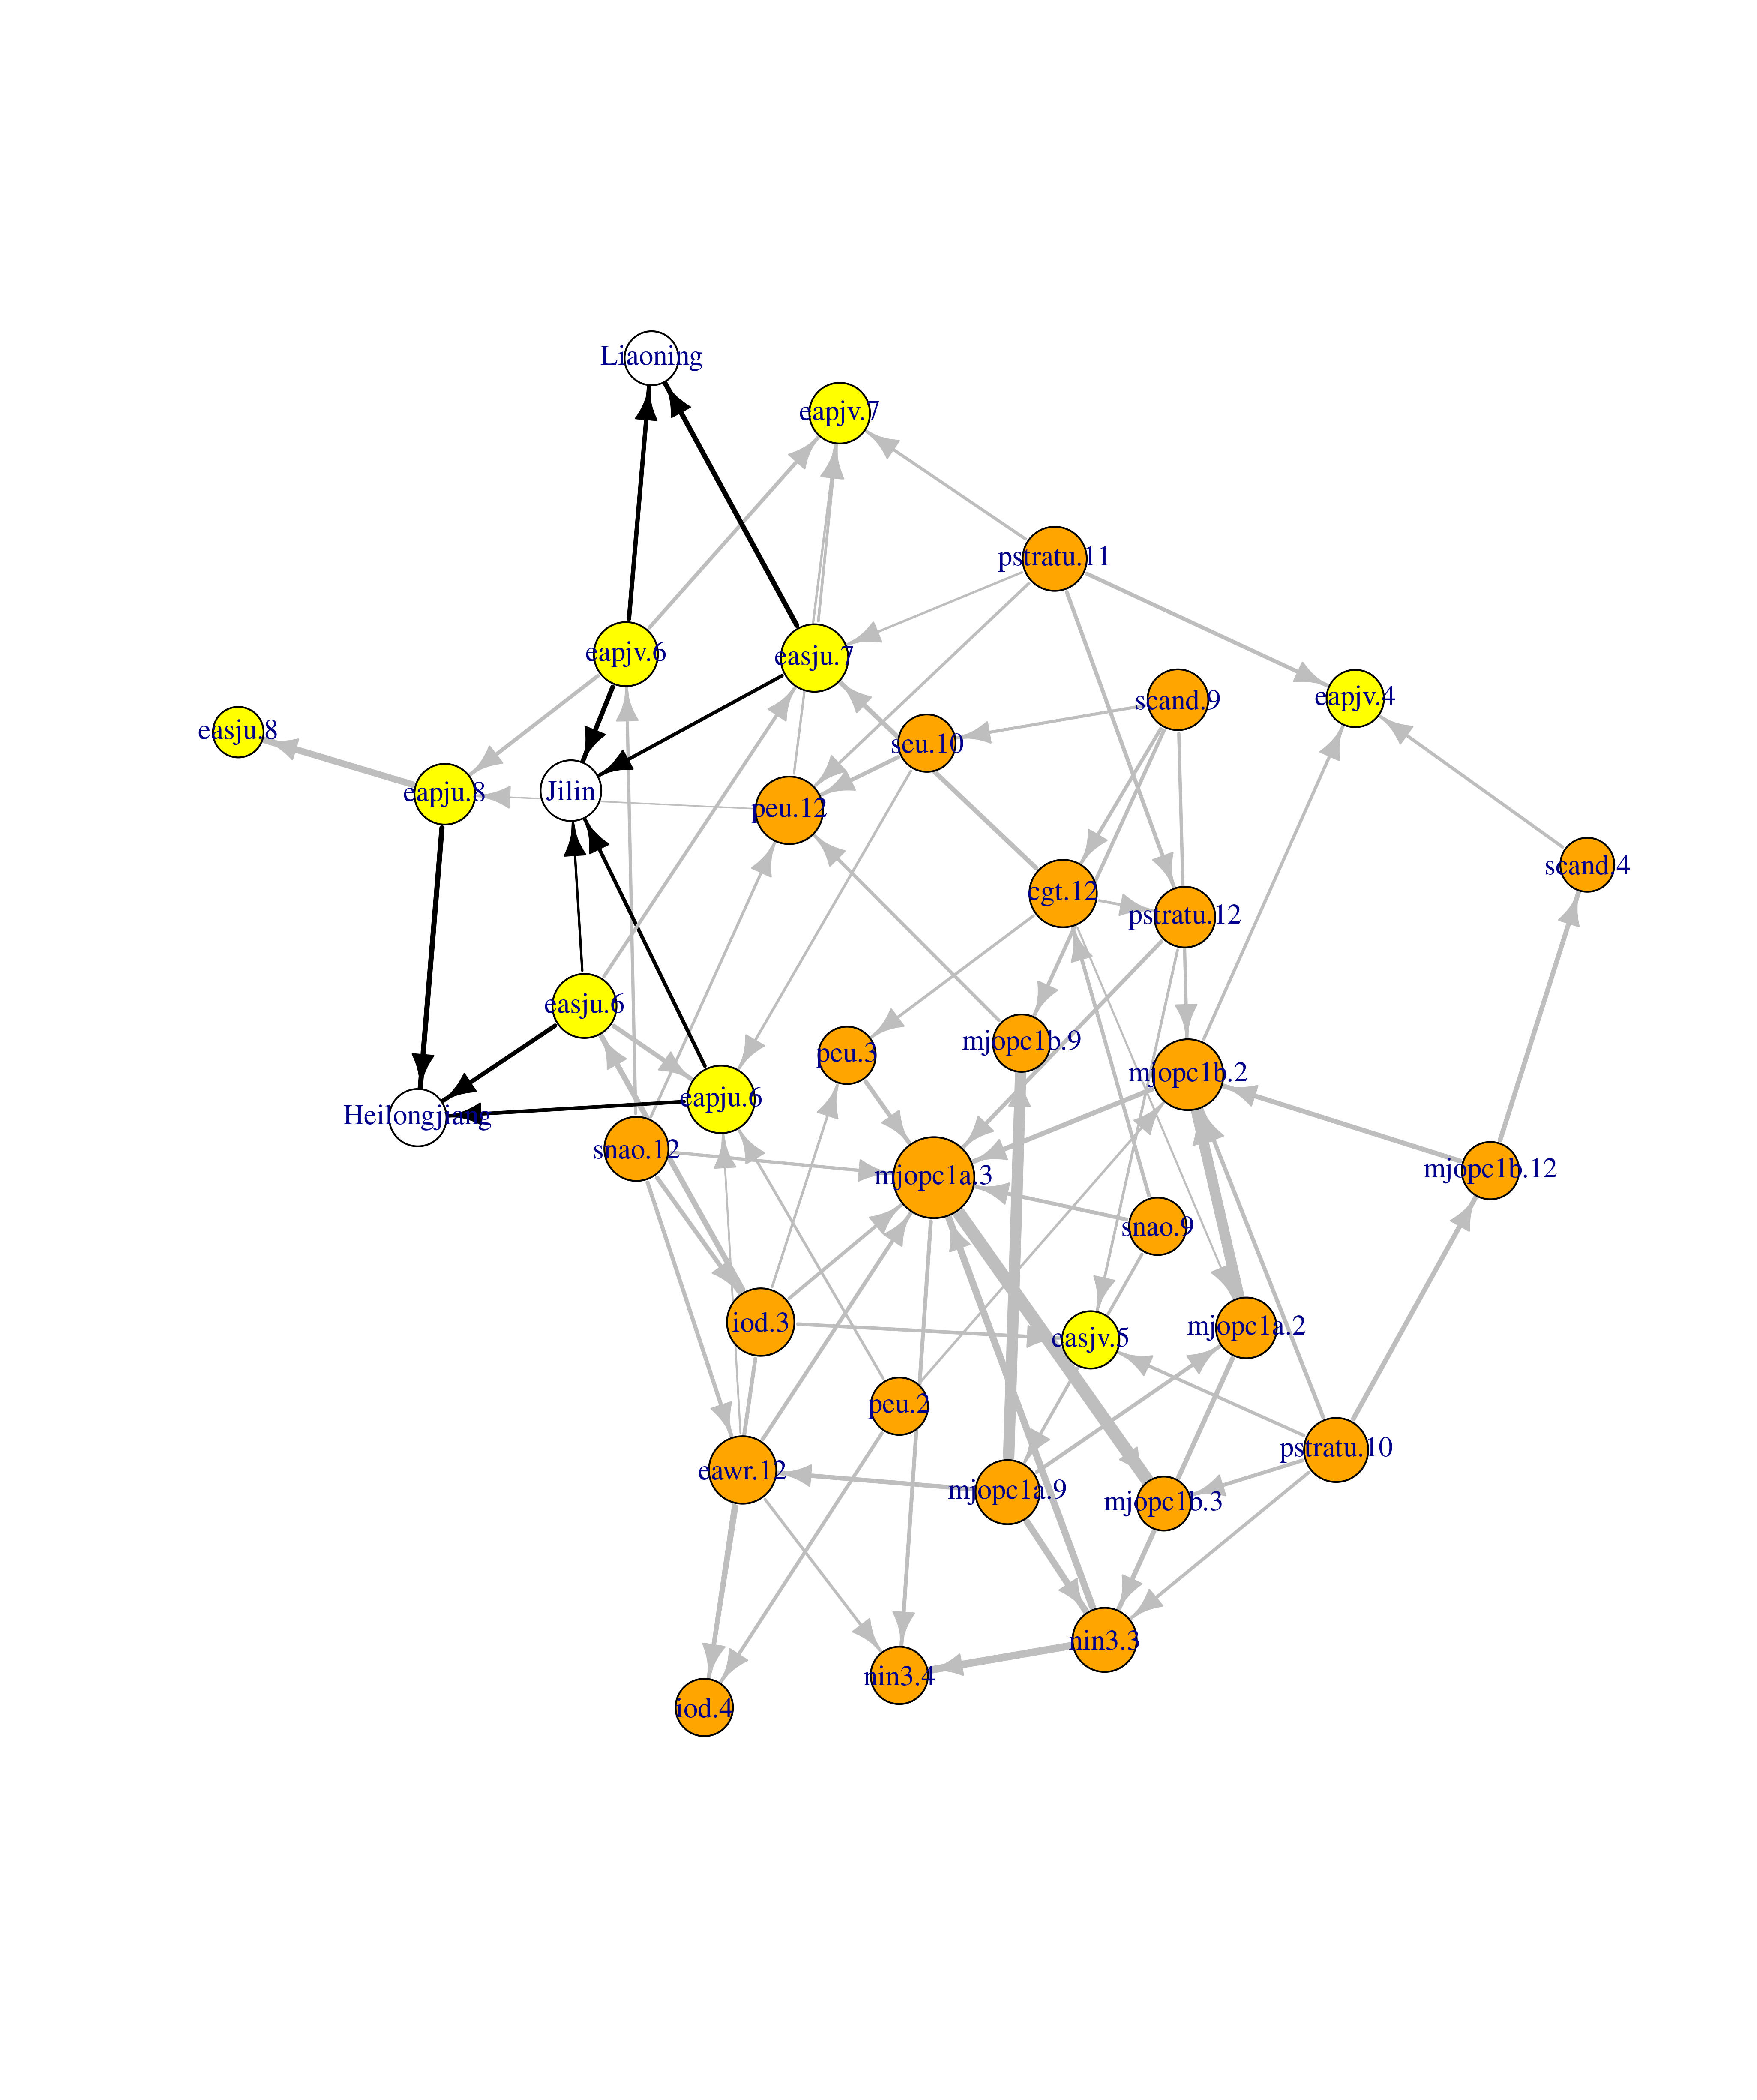

In [47]:
fname = paste('./china_maize_network_',graph_title,'_jet_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep="")
png(fname, width=10.25,height=12.25,units="in",res=400)
plot(bn_graph, 
     layout=bn_graph_layout, 
     edge.width = sqrt(-log(bn_pvalues[,3])), 
     vertex.size = 7.0+0.5*degree(bn_graph), 
     vertex.color = node_colours, 
     cex=4, 
     main=graph_title, 
     resolution=2,
    )
dev.off()
display_png(file=fname, width=750) 

### Figure 7: Climate index cross correlation matrix 

### Figure 8: Predictors vs temperature PCA

### Linear Mixed Effects Model

<a id='section_6'></a>
## Section 6: Statistical forecast
* Statistical forecast of provincial temperatures using linear regression of selected climate indices

We construct statistical forecasts of mean JJA temperature using multiple linear regression models that contain predictors identified within the Bayesian network which connect to the province JJA temperatures via the East Asian jet streams. This approach leads to parsimonious and explainable linear regression models, with good predictive power and minimal predictors. 
To assess the predictive power of these models we generate retrospective out-of-sample forecasts for each year between 1981-2016 using leave-one-out and k-folds cross-validation, calculating the Pearson correlation with observed (ERA5) temperature. 
For comparison, we also assess the performance of forecasts produced by k-fold cross validation of a Bayesian network constructed from the selected climate predictors and the province temperatures.
For additional context, we compare the statistical forecasts against seasonal climate model predictions made using the Met Office decadal model initialised in May each year.

In [48]:
library(repr)
library(ggplot2)
library(patchwork)
library(randomForest)
library(boot)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin




In [49]:
empty_matrix <- function(years, regions){
    empty_df = array(NA, c(length(years), length(regions)))
    rownames(empty_df) = years
    colnames(empty_df) = regions 
    return(empty_df)
}

### Build linear regression model to predict provincial temperatures, using LOOCV to verify

The selected climate indices given in Table 4 are used to build multiple-linear regression models and forecast the mean summer temperatures in each province for 1981-2016, trained and tested using leave-one-out (LOOCV) and k-fold cross-validation.

In [50]:
automate_predict <- function(namex, ydata, xdata, xoos) {
  # function used to prediction of temperature
  xmat = as.matrix(xdata)
  df = data.frame(ydata, xdata)
  colnames(df) = c("Y", paste(namex,1:dim(xmat)[2], sep=""))
  form = as.formula(sprintf("Y ~ %s", paste(names(df)[2:length(names(df))], collapse = " + ")))
  
  model = lm(form, df)
  
  out_of_sample_data <- data.frame(t(xoos))
  cf <-coef(summary(model, complete = TRUE)) 
  colnames(out_of_sample_data) = rownames(cf)[-1]
  pred = predict(model, out_of_sample_data, se.fit = TRUE)$fit
  predict_effects = coef(model)[2:length(coef(model))]*t(out_of_sample_data)
  
  A=c()
  A$model = model
  A$pred = pred
  A$effects = predict_effects
  
  return(A)  
}

In [51]:
bn_cindex_predictors

$Liaoning
[1] "snao.12"    "cgt.12"     "pstratu.11"

$Jilin
[1] "seu.10"     "eawr.12"    "peu.2"      "snao.12"    "iod.3"     
[6] "cgt.12"     "pstratu.11"

$Heilongjiang
[1] "seu.10"  "eawr.12" "peu.2"   "peu.12"  "iod.3"

In [52]:
years = as.numeric(rownames(temp_anoms))
t_anom_loocv = empty_matrix(years, provinces)
t_int = empty_matrix(years, provinces)
t_ent = empty_matrix(years, provinces)
t_abs_loocv = empty_matrix(years, provinces)
t_effcv = array(NA, c(length(years),length(provinces), dim(cindex_anoms)[2]))
dimnames(t_effcv)[[3]] <- colnames(cindex_anoms)

In [53]:
correlation_threshold = critical.r(length(years), 0.2)

for (k in 1:length(provinces)) {

    preds = gsub("[[:punct:]]", "-", bn_cindex_predictors[[provinces[k]]])

    preds_crit = preds[which(abs(cor(cindex_anoms[, preds], temp_anoms[,k])) >= correlation_threshold)]
                          
    if (length(preds_crit) > 0) {
        for (y in 1:length(years)) {
            loo = y
            timesteps = 1:(length(years)-length(loo))
            loo_lm = lm(temp_anoms[-loo,k] ~ timesteps)   
            
            # predict LOO with linear regression model
            tmod = automate_predict(namex = "t", 
                                    ydata = loo_lm$residuals, 
                                    xdata = cindex_anoms[-loo, preds_crit], 
                                    xoos  = cindex_anoms[loo, preds_crit])
            tmod_fit = tmod$model$fitted.values
            t_anom_loocv[y,k] = tmod$pred
            t_effcv[y,k,preds_crit] = tmod$effects
            t_int[y,k] = tmod$model$coefficients[1]
            frac = abs(t_effcv[y,k,preds_crit])/sum(abs(t_effcv[y,k,preds_crit]))
            t_ent[y,k] = -1.0*sum(frac*log(frac))
               
            # absolute temperature prediction
            loo_baseline = predict(loo_lm, data.frame(timesteps = loo), se.fit = TRUE)$fit
            t_abs_loocv[y,k] = t_anom_loocv[y,k] + loo_baseline

        }
    }
}

In [54]:
head(t_anom_loocv)
head(t_abs_loocv)

,Liaoning,Jilin,Heilongjiang
1981,0.2526371,6.202260e-01,0.8088557
1982,0.8399772,7.393518e-01,0.6322725
1983,-0.2874575,-9.549606e-01,-1.0451765
1984,-0.1927106,-6.197193e-05,0.3191113
1985,-1.6359677,-7.817157e-01,0.1835582
1986,0.3150835,-2.437950e-01,-0.4507365


,Liaoning,Jilin,Heilongjiang
1981,0.1981509,0.62914016,0.8698982
1982,0.7282485,0.54943374,0.4183246
1983,-0.2754038,-0.80411303,-0.8538786
1984,-0.2302157,-0.02569162,0.3233238
1985,-1.6292768,-0.79192586,0.1764893
1986,0.3921651,-0.17714362,-0.4219292


### Build Random Forest regression model to predict provincial temperatures, using LOOCV to verify

In [55]:
bn_cindex_predictors

$Liaoning
[1] "snao.12"    "cgt.12"     "pstratu.11"

$Jilin
[1] "seu.10"     "eawr.12"    "peu.2"      "snao.12"    "iod.3"     
[6] "cgt.12"     "pstratu.11"

$Heilongjiang
[1] "seu.10"  "eawr.12" "peu.2"   "peu.12"  "iod.3"

In [56]:
years = as.numeric(rownames(temp_anoms))
t_anom_loocv_rf = empty_matrix(years, provinces)
t_abs_loocv_rf = empty_matrix(years, provinces)

correlation_threshold = critical.r(length(years), 0.2)

for (k in 1:length(provinces)) {

    preds = gsub("[[:punct:]]", "-", bn_cindex_predictors[[provinces[k]]])

    preds_crit = preds[which(abs(cor(cindex_anoms[, preds], temp_anoms[,k])) >= correlation_threshold)]
                          
    if (length(preds_crit) > 0) {
        # Create a random forest regression model iteration of n-1 years
        for (y in 1:length(years)) {
            loo = y
            timesteps = 1:(length(years)-length(loo))
            loo_lm = lm(temp_anoms[-loo,k] ~ timesteps)   

            # predict LOO using Random Forest regression model  
            set.seed(2019)
            loo_rf = randomForest::randomForest(x=cindex_anoms[-loo, preds_crit], 
                                                 y=loo_lm$residuals)
            t_anom_loocv_rf[y,k] = predict(loo_rf, cindex_anoms[loo, preds_crit])
               
            # absolute temperature prediction
            loo_baseline = predict(loo_lm, data.frame(timesteps = loo), se.fit = TRUE)$fit
            t_abs_loocv_rf[y,k] = t_anom_loocv_rf[y,k] + loo_baseline

        }
    }
}

In [57]:
head(t_abs_loocv_rf)
head(t_anom_loocv_rf)

,Liaoning,Jilin,Heilongjiang
1981,0.69456524,1.0546727,1.25864306
1982,0.35532399,0.5518637,-0.08723271
1983,-0.03252129,-0.4609923,-0.35762342
1984,-0.17517284,0.2651204,0.44576010
1985,-0.49764028,-0.1850317,-0.04385312
1986,0.66291007,-0.2728512,-0.67646059


,Liaoning,Jilin,Heilongjiang
1981,0.74905138,1.0457586,1.19760064
1982,0.46705269,0.7417818,0.12671521
1983,-0.04457498,-0.6118399,-0.54892130
1984,-0.13766776,0.2907501,0.44154760
1985,-0.50433122,-0.1748215,-0.03678419
1986,0.58582847,-0.3395025,-0.70526786


### Bootstrapping linear model to get confidence intervals for predictions

In [58]:
data_cor <- function(data, i){
 d <- data[i,] 
 return(cor(d[,1], d[,2]))
}

In [59]:
x = t_anom_loocv
y = temp_anoms
for (p in provinces) {
    set.seed(1)
    print(p)
    data = cbind(x[, p], y[, p])
    bootstrap = boot(data, data_cor, R = 1000)
    print(bootstrap)
    print(boot.ci(boot.out=bootstrap))
    print("----------------------------")
    }

[1] "Liaoning"

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data, statistic = data_cor, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.6183284 0.002705394   0.0923039
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4347,  0.7965 )   ( 0.4577,  0.8325 )  

Level     Percentile            BCa          
95%   ( 0.4042,  0.7790 )   ( 0.3689,  0.7638 )  
Calculations and Intervals on Original Scale
[1] "----------------------------"
[1] "Jilin"

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data, statistic = data_cor, R = 1000)


Bootstrap Statistics :
     original     bias    std. error
t1* 0.6562134 0.00837725  0.07921791
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap)

Intervals : 
Level      Normal              Basic         
95%   ( 

### Boostrapping dynamical Seasonal forecast (DePreSys) to get confidence intervals of performance

In [60]:
x = depresys_anoms
y = temp_anoms
for (p in provinces) {
    set.seed(1)
    print(p)
    data = cbind(x[, p], y[, p])
    bootstrap = boot(data, data_cor, R = 1000)
    print(bootstrap)
    print(boot.ci(boot.out=bootstrap))
    print("----------------------------")
    }

[1] "Liaoning"

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data, statistic = data_cor, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.2696603 0.007538836   0.1343295
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap)

Intervals : 
Level      Normal              Basic         
95%   (-0.0012,  0.5254 )   ( 0.0085,  0.5352 )  

Level     Percentile            BCa          
95%   ( 0.0041,  0.5308 )   (-0.0387,  0.4985 )  
Calculations and Intervals on Original Scale
[1] "----------------------------"
[1] "Jilin"

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data, statistic = data_cor, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.2924243 -0.0006353441   0.1422674
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap)

Intervals : 
Level      Normal              Basic         
95

### 5-fold cross validated linear regression


### 5-fold cross validation of Bayesian network
Assess the performance of forecasts produced by the Bayesian network using k-fold cross validation, with five folds.

Specifically a cross validation of temperature predictions in the network for each province.

In [61]:
t_5fcv_bn = c()
for (p in provinces) {
    set.seed(1)
    t_5fcv_bn[p] = bnlearn::bn.cv(data = bn_variables_df, 
                                  bn = bn_structure_avg, 
                                  loss = "cor", 
                                  loss.args = list(target = p), 
                                  k=5, 
                                  runs=50)
}
t_5fcv_bn

$Liaoning

  k-fold cross-validation for Bayesian networks

  target network structure:
   [snao.9][snao.12][scand.9][peu.2][pstratu.10][pstratu.11][iod.3|snao.12]
   [seu.10|scand.9][cgt.12|snao.9:scand.9][mjopc1a.9|snao.9]
   [mjopc1b.12|pstratu.10][eapjv.6|snao.12][scand.4|mjopc1b.12]
   [eawr.12|snao.12:mjopc1a.9][peu.3|iod.3:cgt.12][pstratu.12|cgt.12:pstratu.11]
   [mjopc1a.2|cgt.12:mjopc1a.9][mjopc1b.9|scand.9:mjopc1a.9][easju.6|iod.3]
   [iod.4|iod.3:eawr.12:peu.2][nin3.3|pstratu.10:mjopc1a.9:mjopc1a.2]
   [peu.12|seu.10:snao.12:pstratu.11:mjopc1b.9]
   [mjopc1b.2|scand.9:peu.2:pstratu.10:mjopc1a.2:mjopc1b.12]
   [eapju.6|seu.10:eawr.12:peu.2:easju.6][easju.7|cgt.12:pstratu.11:easju.6]
   [easjv.5|iod.3:pstratu.10:pstratu.12]
   [mjopc1a.3|iod.3:nin3.3:snao.9:snao.12:eawr.12:peu.3:pstratu.12:mjopc1b.2]
   [eapju.8|peu.12:eapjv.6][eapjv.4|scand.4:pstratu.11:mjopc1b.2]
   [eapjv.7|peu.12:pstratu.11:eapjv.6:easju.7][Liaoning|eapjv.6:easju.7]
   [Jilin|eapju.6:eapjv.6:easju.6:easju.

### Plot timerseries of temperature predictions vs ERA5 vs DePreSys

Generate a timeseries plot of mean JJA temperature for each province, containing the ERA5 data (black) and predicted values (red dashed)

In [62]:
subplots = list()
colors = c("ERA 5"="black", "Linear model"="red", "DePreSys"="red")
linetype = c("ERA 5"=1, "Linear model"=5, "DePreSys"=3)

for (p in provinces) {
    obs <- temp_abs[,p]
    linear_model <- t_abs_loocv[,p]
    seasonal_model <- depresys_abs[,p]
    years <- as.numeric(names(obs))
    df <- data.frame(years, obs, linear_model, seasonal_model)
    
    line_plot = ggplot(df, aes(x=years, group = 1)) +
        geom_line(aes(y=obs, color = "ERA 5", linetype="ERA 5")) + 
        geom_line(aes(y=linear_model, color ="Linear model", linetype="Linear model")) + 
        geom_line(aes(y=seasonal_model, color ="DePreSys", linetype="DePreSys")) + 
        # ggtitle(paste(rawToChar(as.raw(96+k)), ") ", provinces[k], sep="")) + 
        ggtitle(p) + 
        xlab("Year") + 
        scale_x_continuous(breaks = seq(1980, 2016, 5)) +
        ylab("Temperature anomaly (\u00B0C)") +
        scale_color_manual(values=colors) +
        scale_linetype_manual(values=linetype) + 
        labs(color="", linetype="") +
        theme(text = element_text(size=16),
             legend.key.width=unit(1.2,"cm")) 
    
    subplots[[p]] = line_plot
    
}

Combine the plots into a single figure

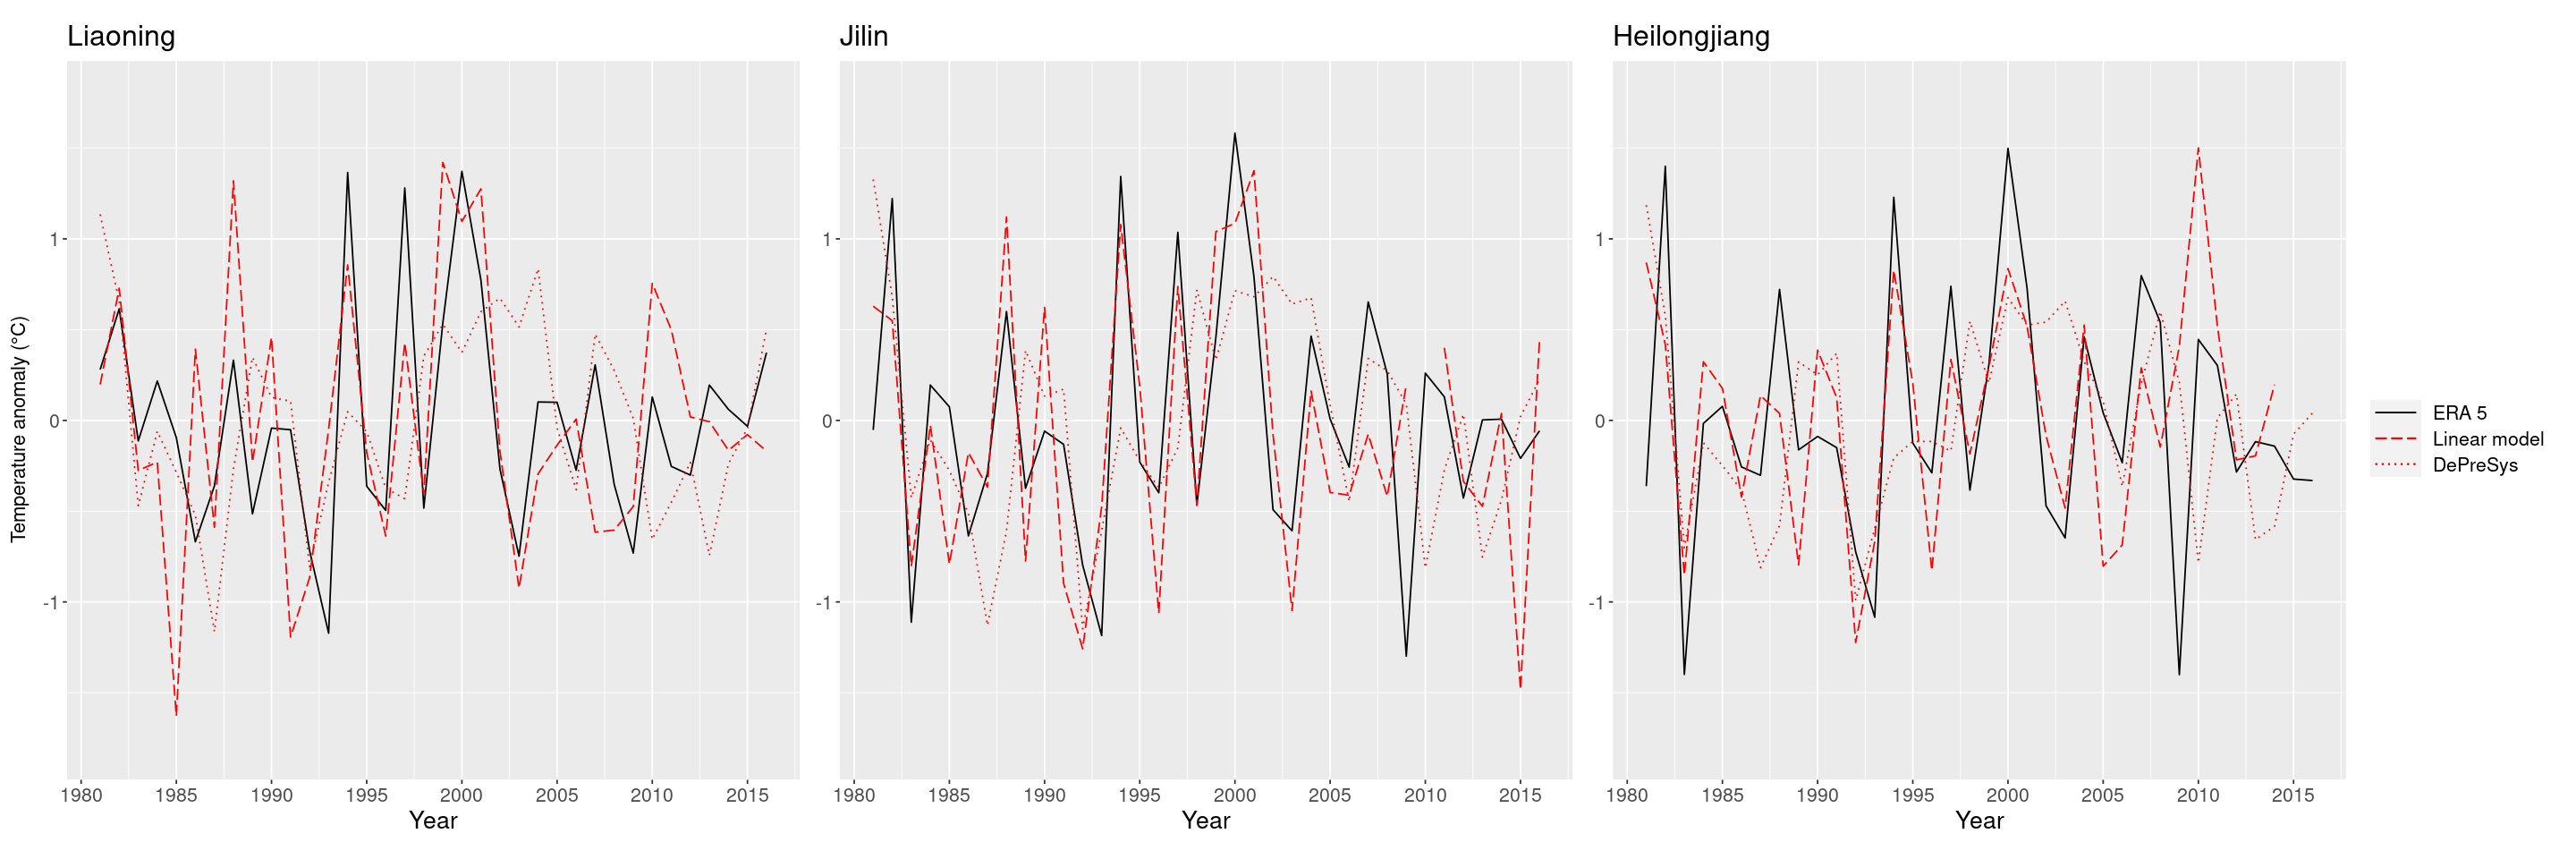

In [63]:
# adjust width of plot in notebook
options(repr.plot.width=24, repr.plot.height=8)

# combine subplots, add a common legend and ylimit, using patchwork notation
plot = subplots[["Liaoning"]] + subplots[["Jilin"]] + subplots[["Heilongjiang"]] + patchwork::plot_layout(guides = "collect") & ylim(-1.8, 1.8)

# add a common y label
patchwork::wrap_elements(plot & ylab(NULL)) +
  labs(tag = "Temperature anomaly (\u00B0C)") +
  theme(
    plot.tag = element_text(angle = 90),
    plot.tag.position = "left"
  )